In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import sys
import copy 
from time import time

from astropy.table import Table, vstack

import numpy as np 
import emcee

import scipy.ndimage
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.mlab as ml
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator

from astroML.stats import binned_statistic_2d

from cap_loess_2d import loess_2d
from cap_plot_velfield import plot_velfield

%config InlineBackend.figure_format='retina'
plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12.0
plt.rc('text', usetex=True)

from hsc_massive import \
    s16a_path, \
    sample_selection, \
    prepare_sed, \
    catalog_summary, \
    mass_function, \
    smhm, \
    plotting
    
from um_model_plot import \
    plot_logmh_sig_logms_tot, \
    plot_logmh_logms_tot, \
    display_obs_smf, \
    plot_best_fit_scatter_relation


In [2]:
from um_ins_exs_model import InsituExsituModel

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Test basic model setup

In [3]:
um_test = InsituExsituModel()

# Input stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Input weak lensing profile sample: s16a_wide2_massive_boxbin3
# There are 15 weak lensing profiles in this sample
# Pre-computed SMF for inner logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_11.5.fits
# Pre-computed SMF for total logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m100_11.5.fits
# Pre-computed full SMF: s82_total_smf_z0.15_0.43.fits
# The volume of the HSC data is    102060083.62 Mpc^3
# Using logm_10 as inner stellar mass.
# Using logm_100 as total stellar mass.
# For inner stellar mass: 
    10 bins at 10.80 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.50 < logMtot < 12.20
# The volume of the UniverseMachine mock is    205348196.23 Mpc^3


#### Relation between halo mass and the total stellar mass within the halo

# Use 385125 galaxies for the fitting...
# SHMR : logms_halo = 0.7551 x logmh_vir + 1.4931


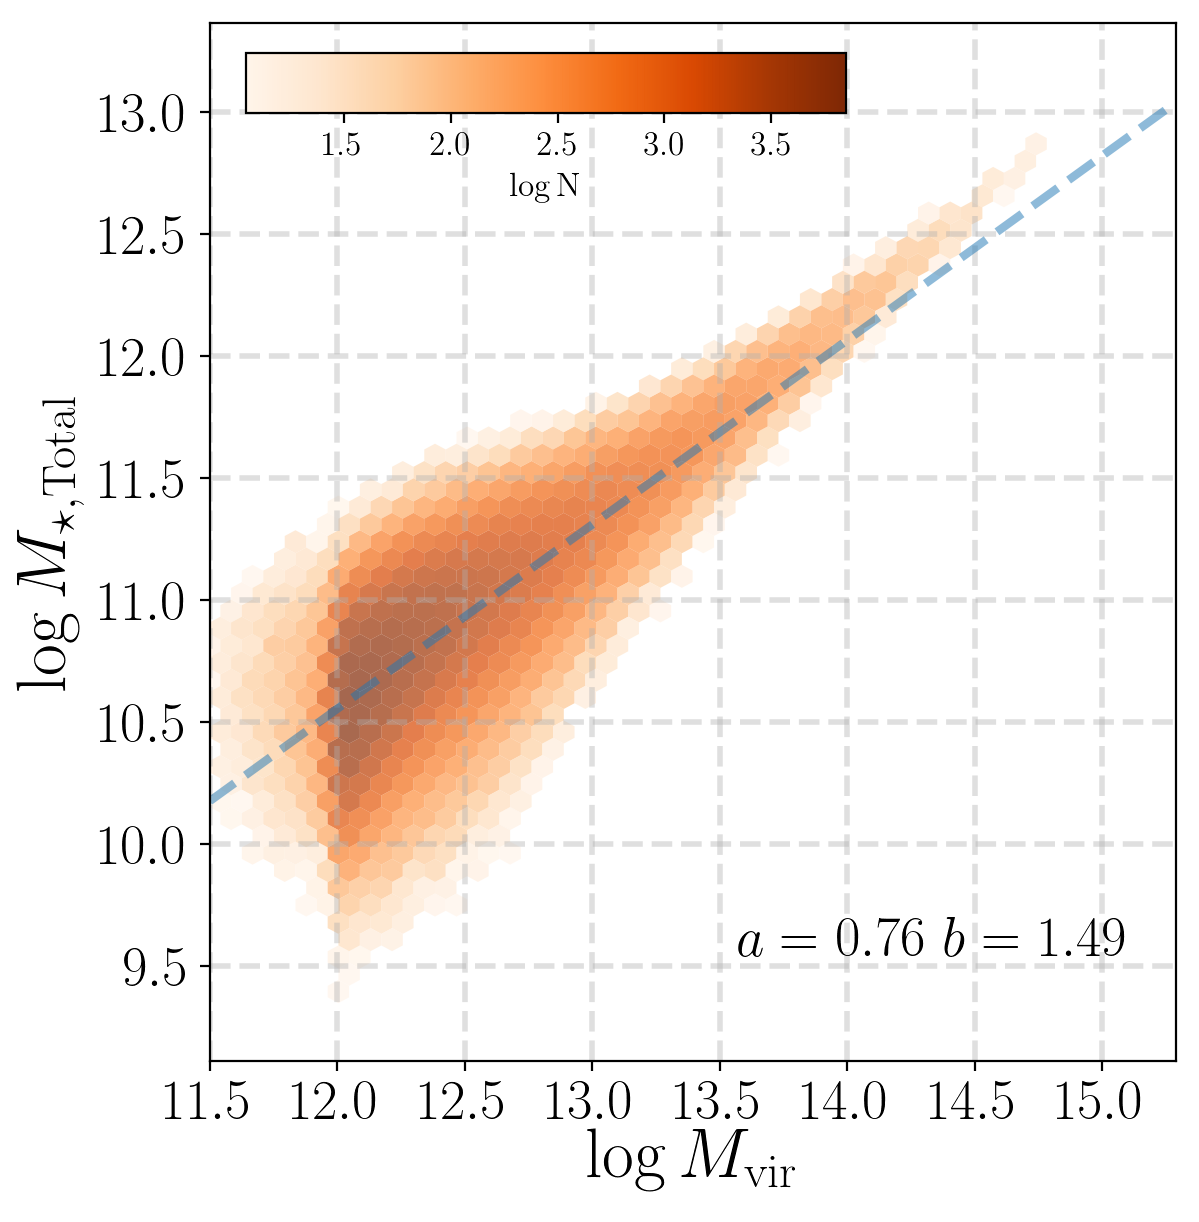

In [39]:
shmr_a, shmr_b = um_test.mockFitSimpleSHMR(um_min_mvir=11.5)

um_cen = um_test.um_mock[um_test.um_mock['mask_central']]
um_cen = um_cen[um_cen['logmh_vir'] > 11.5]

fig_logmh_logms_tot = plot_logmh_logms_tot(um_cen['logmh_vir'], 
                                           um_cen['logms_halo'],
                                           shmr_a, shmr_b)

In [40]:
np.nanmax(um_cen['logmh_vir'])

15.288249225571986

#### Relation between halo mass and the scatter of total stellar mass within the halo

# Mh-SigMs : Sig(logms_halo) = -0.0824 x logmh_vir + 1.2737


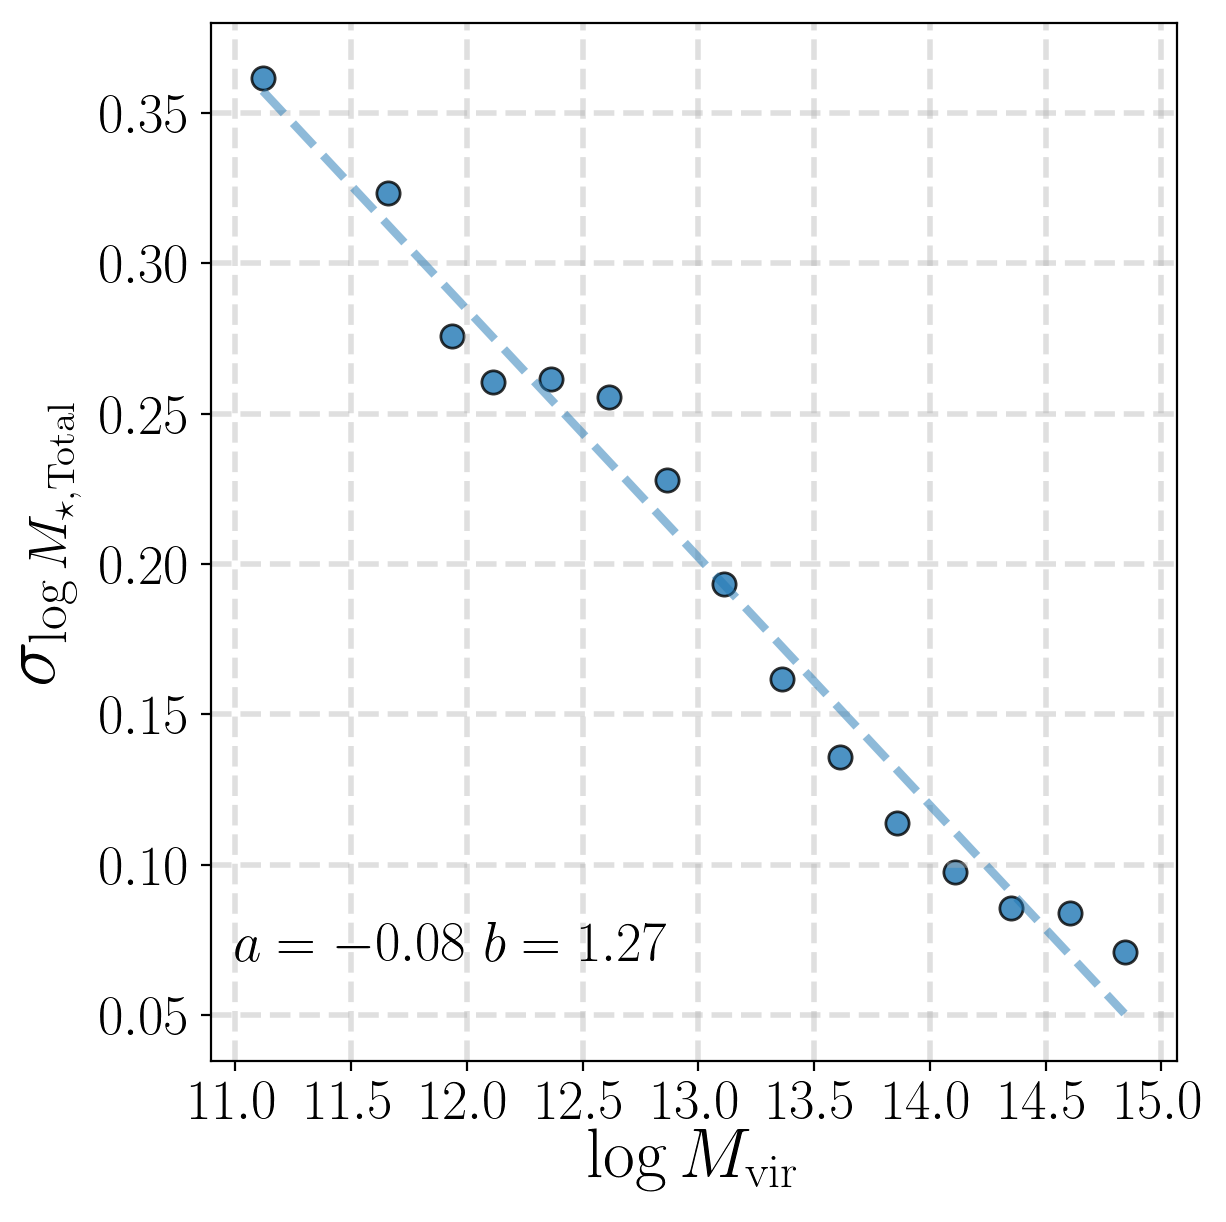

In [16]:
sigms_a, sigms_b, logmh_cen, sig_logms_tot = um_test.mockFitSimpleMhScatter(um_min_mvir=11.5, 
                                                                            n_bins=15)

fig_logmh_sig_logms_tot = plot_logmh_sig_logms_tot(logmh_cen, sig_logms_tot,
                                                   sigms_a, sigms_b)

#### Display the obseved stellar mass functions

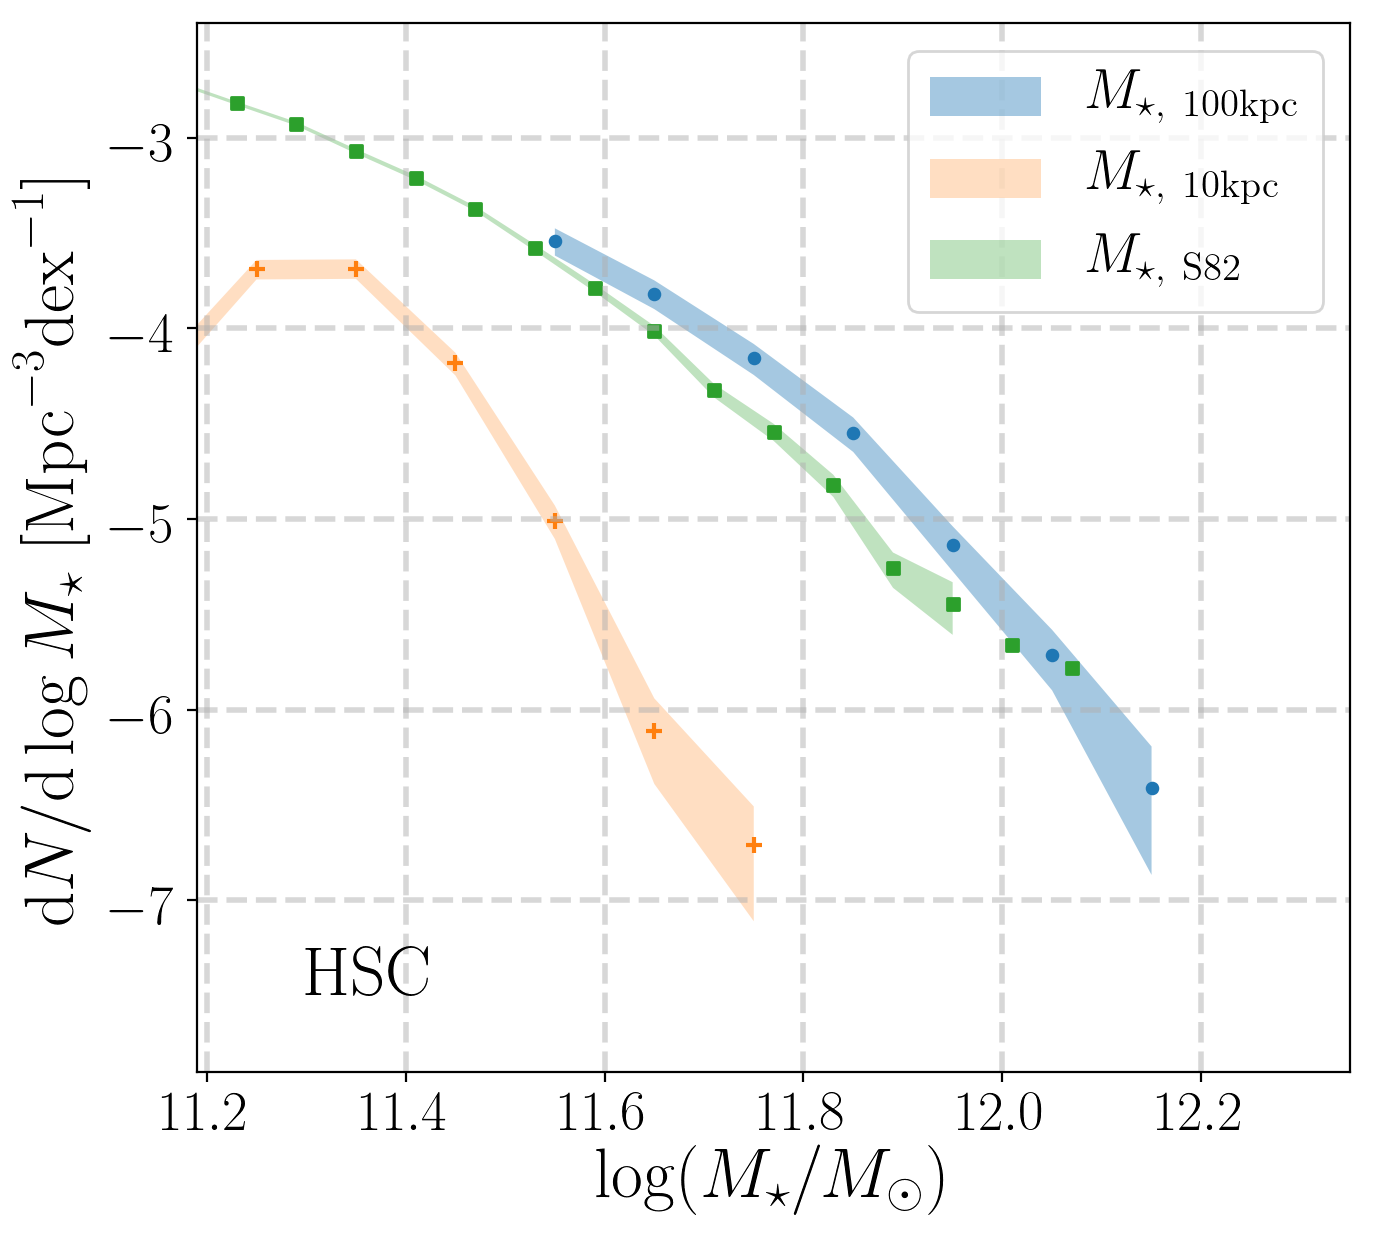

In [20]:
fig_obs_smf = display_obs_smf(um_test.obs_smf_tot,
                              um_test.obs_smf_inn,
                              obs_smf_full=um_test.obs_smf_full) 

### Test making simple model predicitons

In [4]:
um_test = InsituExsituModel(model_type='simple')

param_simple = (0.712, 1.49, -0.07, 1.274)

um_mass_predicted = um_test.umPredictMass(param_simple, 
                                          constant_bin=False)

(logms_inn_mod, logms_tot_mod, 
 logms_halo_mod, mask_tot, um_mock_use) = um_mass_predicted

# Input stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Input weak lensing profile sample: s16a_wide2_massive_boxbin3
# There are 15 weak lensing profiles in this sample
# Pre-computed SMF for inner logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_11.5.fits
# Pre-computed SMF for total logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m100_11.5.fits
# Pre-computed full SMF: s82_total_smf_z0.15_0.43.fits
# The volume of the HSC data is    102060083.62 Mpc^3
# Using logm_10 as inner stellar mass.
# Using logm_100 as total stellar mass.
# For inner stellar mass: 
    10 bins at 10.80 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.50 < logMtot < 12.20
# The volume of the UniverseMachine mock is    205348196.23 Mpc^3


/usr/local/lib/python2.7/site-packages/halotools/utils/inverse_transformation_sampling.py:177: UserWarning: The build_cdf_lookup function was called with the (optional) ``npts_lookup_table`` argument set to 1000.
However, the number of data points in your data table npts_y = 70.
The default behavior in this situation is to overwrite ``npts_lookup_table`` = ``npts_y``,
so that every point in the data set is used to build the lookup table.
  warn(warning_msg.format(npts_lookup_table, npts_y))
/usr/local/lib/python2.7/site-packages/halotools/utils/inverse_transformation_sampling.py:177: UserWarning: The build_cdf_lookup function was called with the (optional) ``npts_lookup_table`` argument set to 1000.
However, the number of data points in your data table npts_y = 107.
The default behavior in this situation is to overwrite ``npts_lookup_table`` = ``npts_y``,
so that every point in the data set is used to build the lookup table.
  warn(warning_msg.format(npts_lookup_table, npts_y))


In [5]:
%timeit um_mod_predicted = um_test.umPredictModel(param_simple, constant_bin=False)

1 loop, best of 3: 268 ms per loop


In [6]:
%timeit um_test.lnLike(param_simple)

1 loop, best of 3: 242 ms per loop


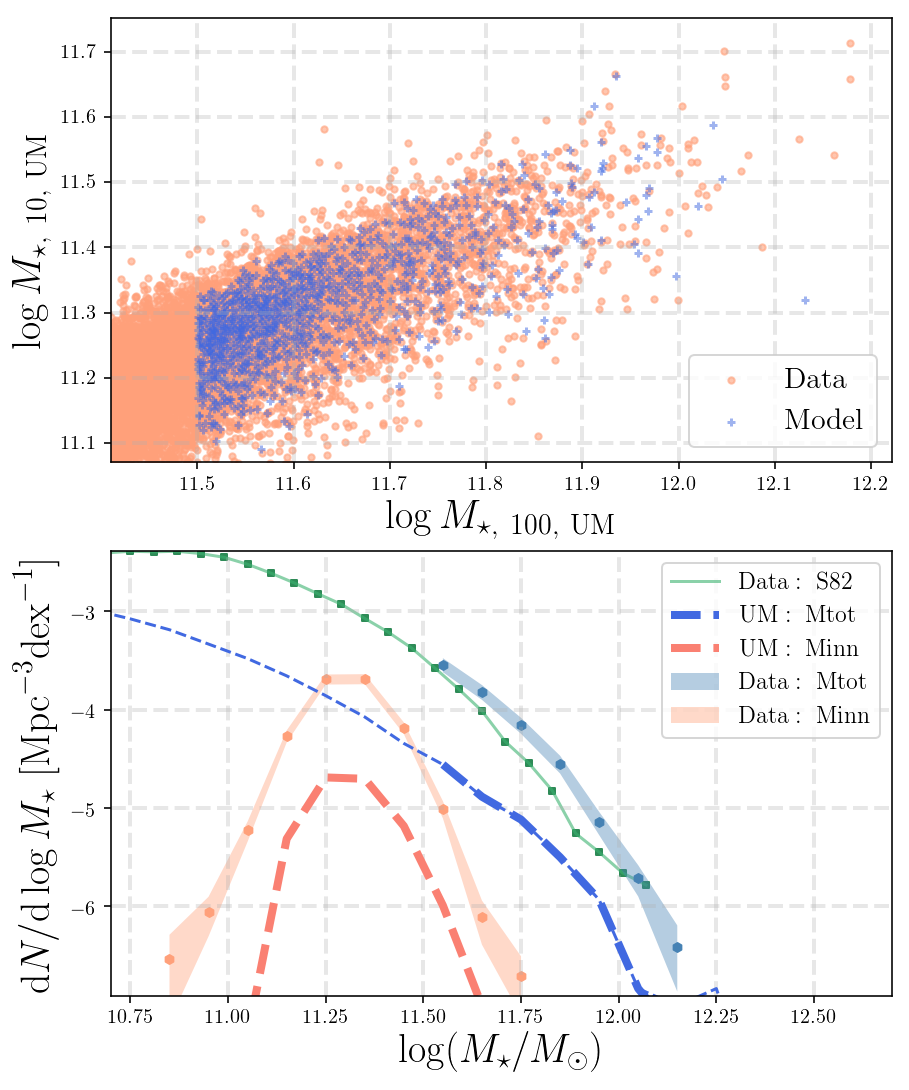

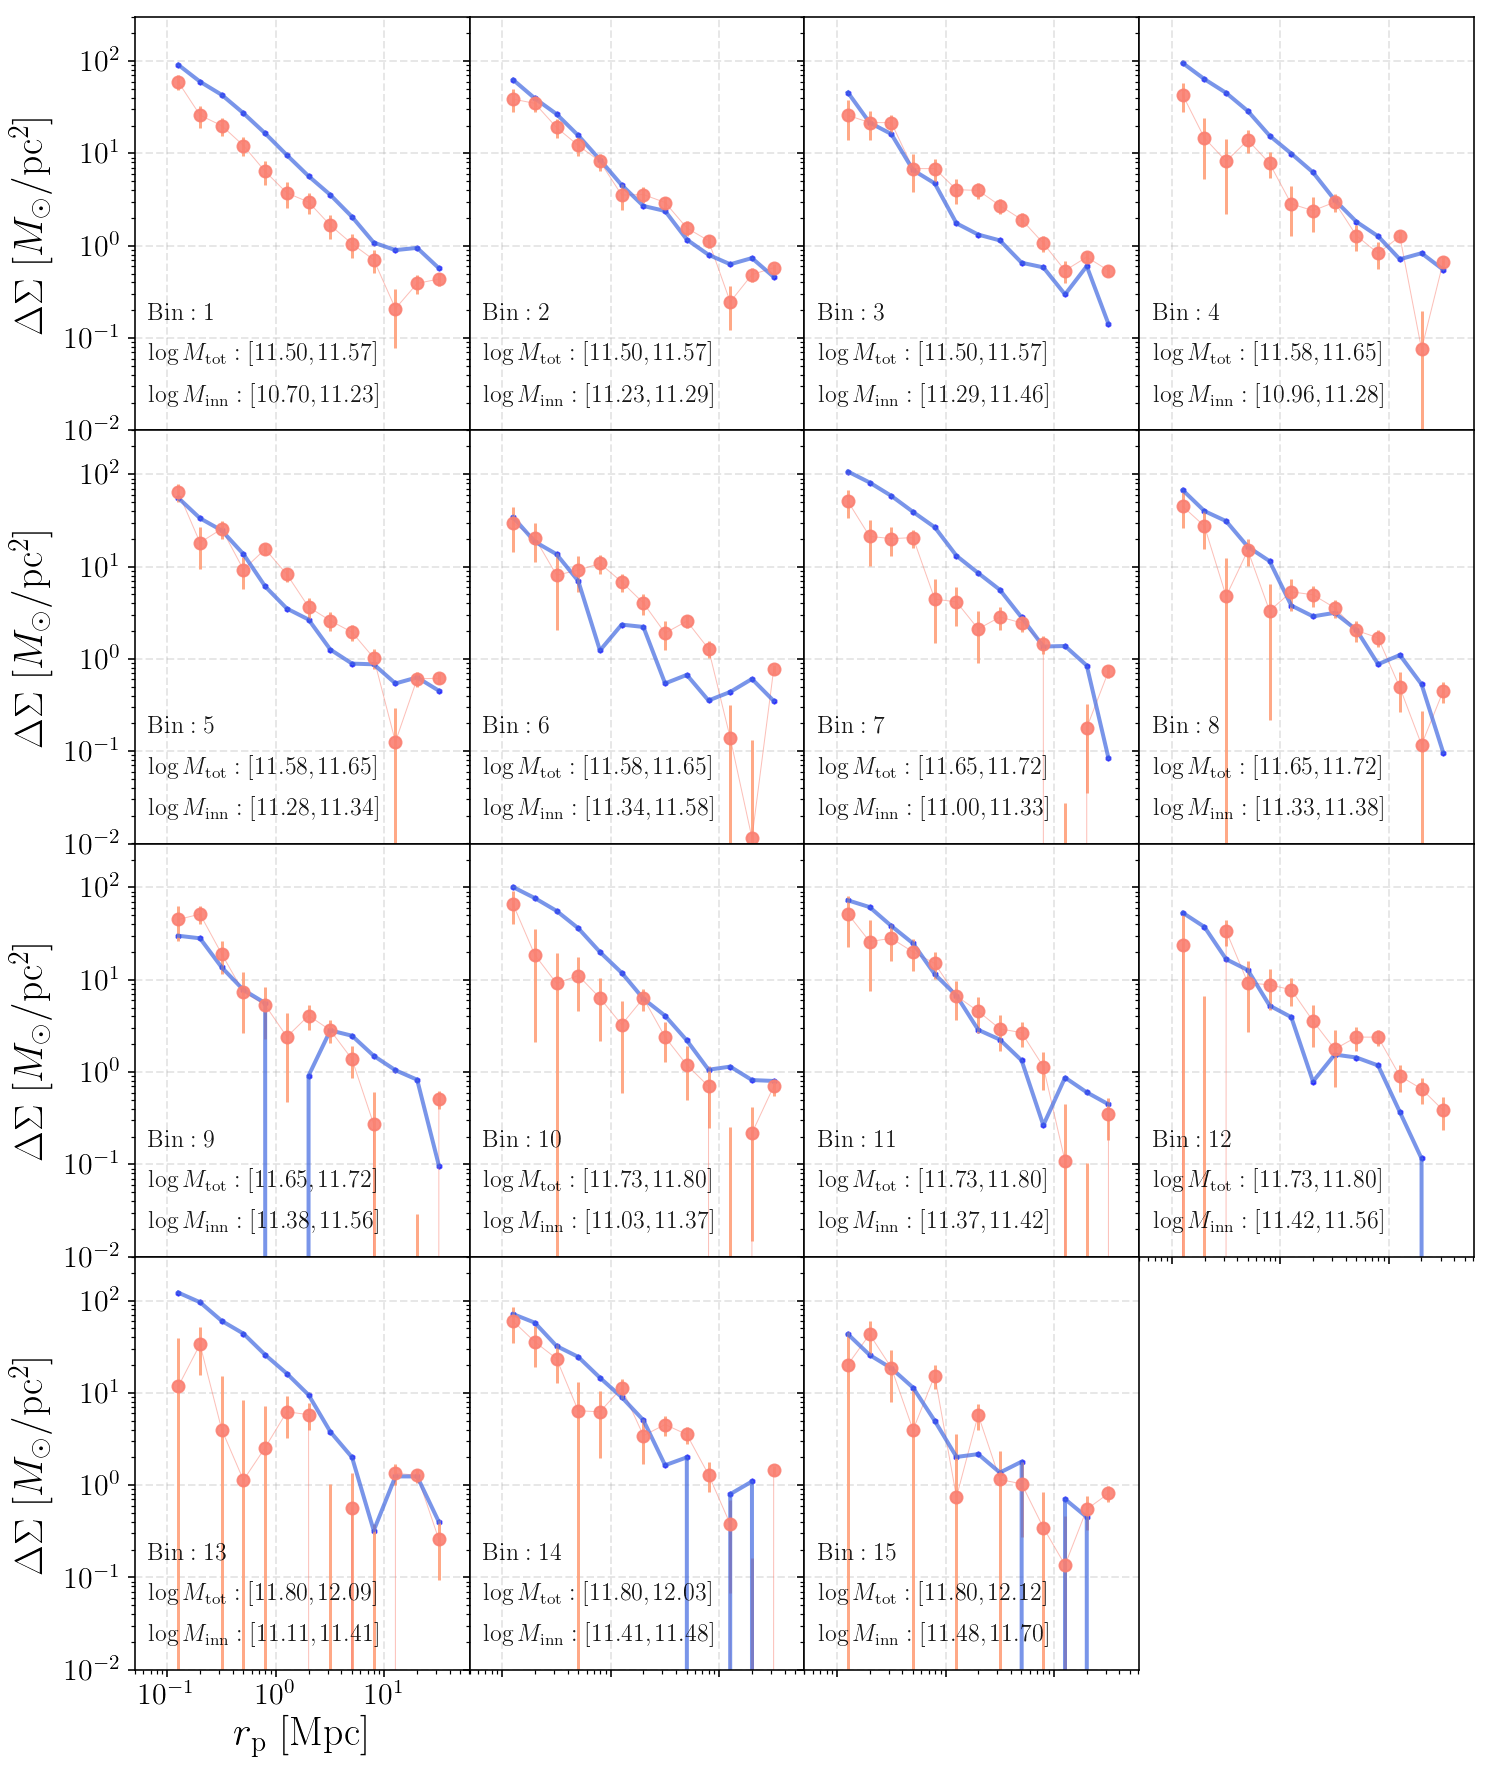

In [7]:
um_mod_predicted = um_test.umPredictModel(param_simple, 
                                          plotSMF=True, 
                                          plotWL=True,
                                          constant_bin=False)

(um_smf_tot, um_smf_inn, um_wl_profs, 
 logms_inn_mod, logms_tot_mod, logms_halo_mod, 
 mask_tot, um_mock_use) = um_mod_predicted

In [145]:
xx = logms_tot_mod
yy = logms_inn_mod
zz = um_mock_use['logmh_vir']

xMin, xMax = np.nanmin(xx), np.nanmax(xx)
yMin, yMax = np.nanmin(yy), np.nanmax(yy)
zMin, zMax = np.nanmin(zz), np.nanmax(zz)

zz_count, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                               'count', 
                                               bins=50)

zz_median, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                                np.nanmedian, 
                                                bins=50)

zz_sigma, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                               np.nanstd, 
                                               bins=50)
xcen = (xedges[0:-2] + xedges[1:-1]) / 2
ycen = (yedges[0:-2] + yedges[1:-1]) / 2

(10.81, 11.800000000000001)

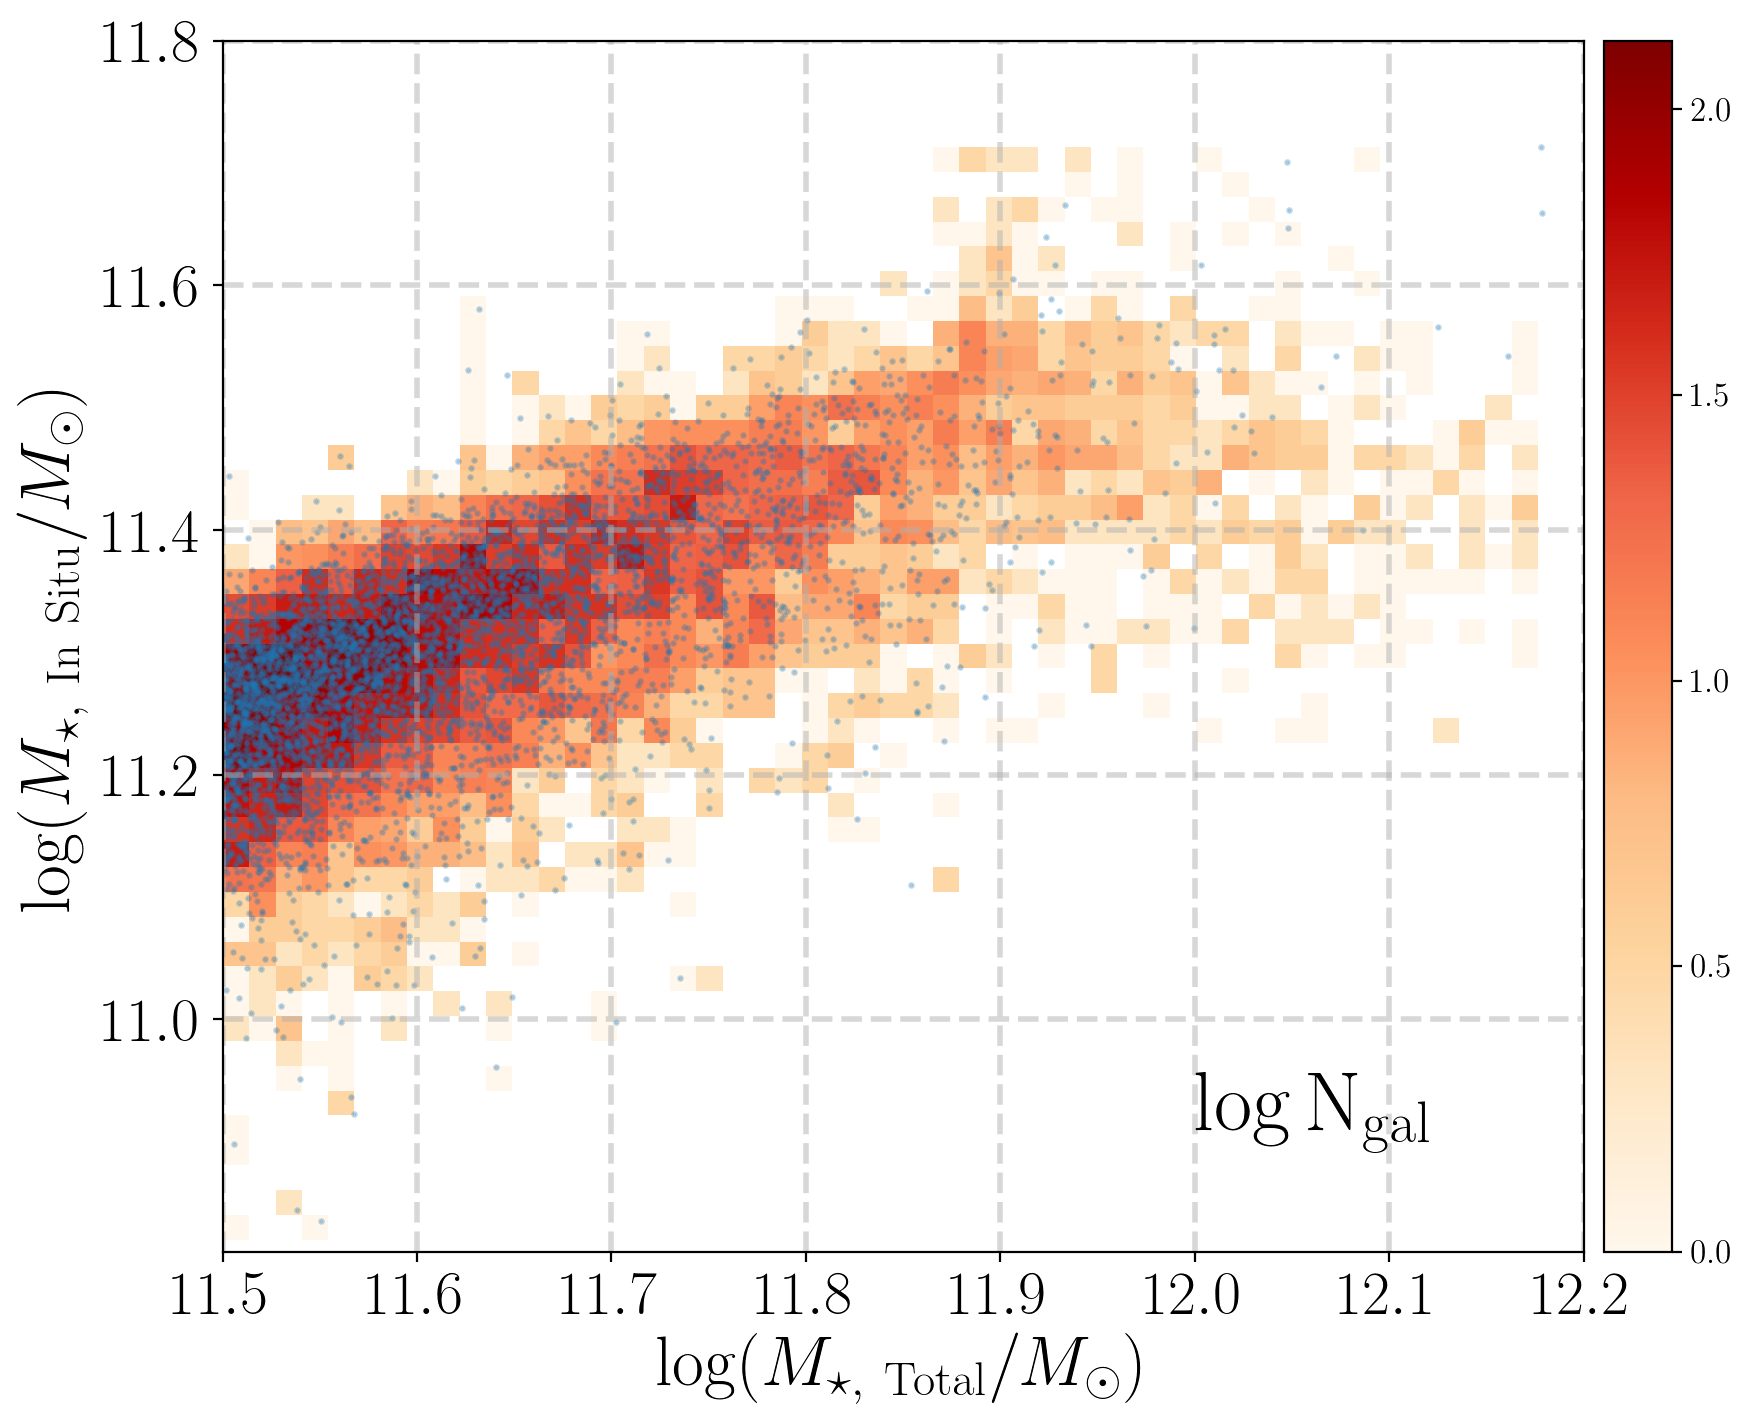

In [146]:
# --------------------------------------------------------------------------------------- #
xtickFormat='$\mathbf{%4.1f}$'
ytickFormat='$\mathbf{%4.1f}$'

ORG = plotting.ORG
BLK = plotting.BLK

nColors = 30
nTicks = 10


# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

HM = ax1.imshow(np.log10(zz_count.T), origin='lower',
                extent=[xedges[0], xedges[-1], 
                        yedges[0], yedges[-1]],
                aspect='auto', interpolation='nearest', 
                cmap=ORG)

ax1.set_xlabel('$\log (M_{\star,\ \mathrm{Total}}/M_{\odot})$', size=25)
ax1.set_ylabel('$\log (M_{\star,\ \mathrm{In\ Situ}}/M_{\odot})$', size=25)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
    
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
cTicks = MaxNLocator(nTicks).tick_values(0, 5)
cbar = plt.colorbar(HM, cax=cax, ticks=cTicks)
cbar.solids.set_edgecolor("face") 

ax1.scatter(um_test.obs_logms_tot,
            um_test.obs_logms_inn, s=2, alpha=0.25)

ax1.text(12.0, 10.9, r'$\log\mathrm{N_{gal}}$', size=30)

# --------------------------------------------------------------------------------------- #
## X, Y limits
ax1.set_xlim(um_test.obs_smf_tot_min, um_test.obs_smf_tot_max)
ax1.set_ylim(10.81, um_test.obs_smf_inn_max)

(10.81, 11.800000000000001)

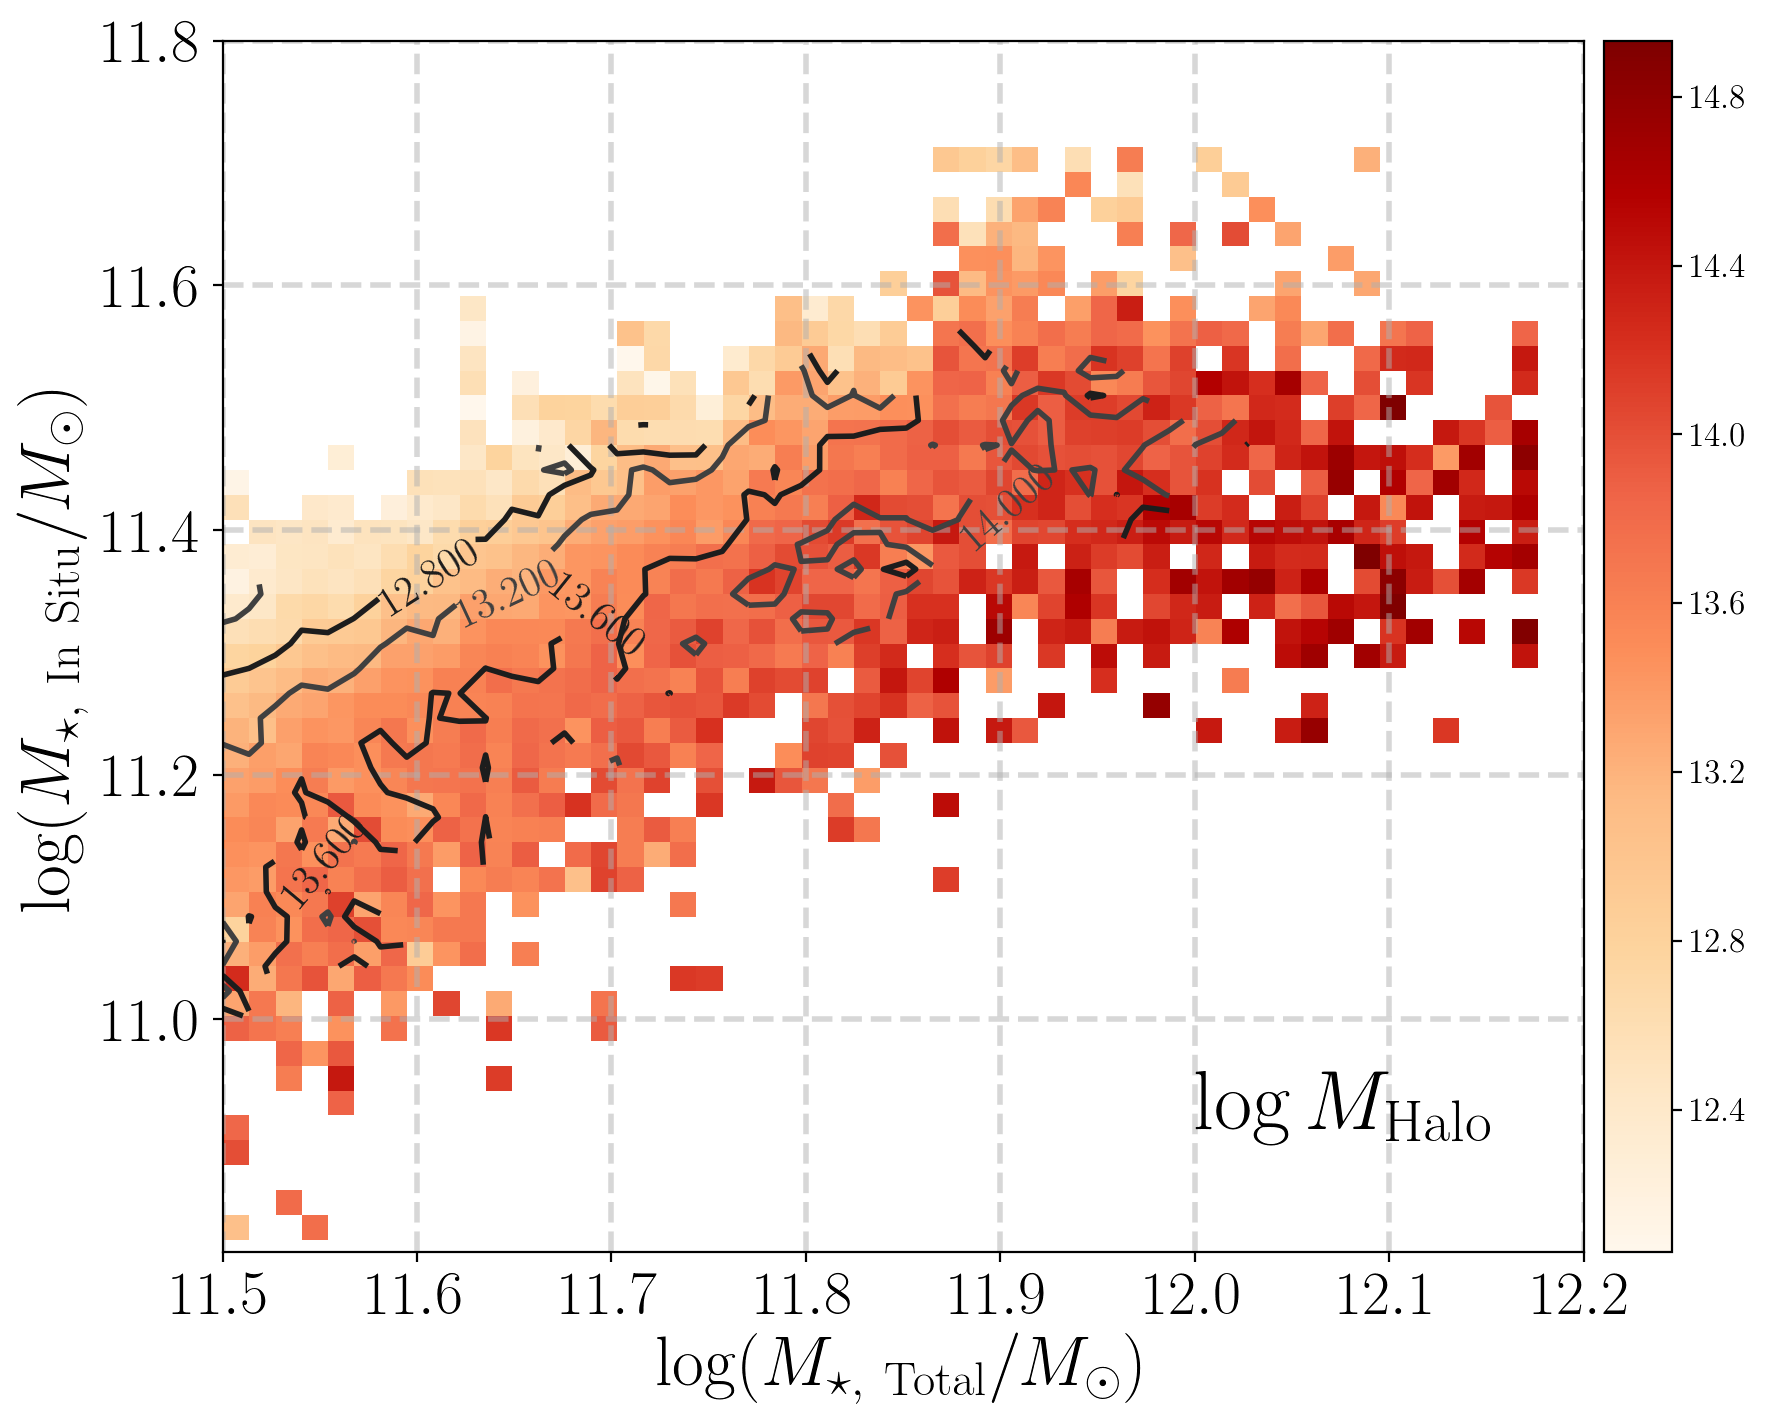

In [148]:
# --------------------------------------------------------------------------------------- #
xtickFormat='$\mathbf{%4.1f}$'
ytickFormat='$\mathbf{%4.1f}$'

ORG = plotting.ORG
BLK = plotting.BLK

nColors = 30
nTicks = 10

# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

HM = ax1.imshow(zz_median.T, origin='lower',
                extent=[xedges[0], xedges[-1], 
                        yedges[0], yedges[-1]],
                aspect='auto', interpolation='nearest', 
                cmap=ORG)

CT = ax1.contour(xedges[:-1], yedges[:-1], gaussian_filter(zz_median.T, 0.2), 
                 6, linewidths=2.0, 
                 colors=[BLK(0.8), BLK(0.9)], 
                 extend='neither')
ax1.clabel(CT, inline=1, fontsize=15)

ax1.set_xlabel('$\log (M_{\star,\ \mathrm{Total}}/M_{\odot})$', size=25)
ax1.set_ylabel('$\log (M_{\star,\ \mathrm{In\ Situ}}/M_{\odot})$', size=25)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
    
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
cTicks = MaxNLocator(nTicks).tick_values(zMin, zMax)
cbar = plt.colorbar(HM, cax=cax, ticks=cTicks)
cbar.solids.set_edgecolor("face") 

ax1.text(12.0, 10.9, r'$\log M_{\mathrm{Halo}}$', size=30)

# --------------------------------------------------------------------------------------- #
## X, Y limits
ax1.set_xlim(um_test.obs_smf_tot_min, um_test.obs_smf_tot_max)
ax1.set_ylim(10.81, um_test.obs_smf_inn_max)

(10.81, 11.800000000000001)

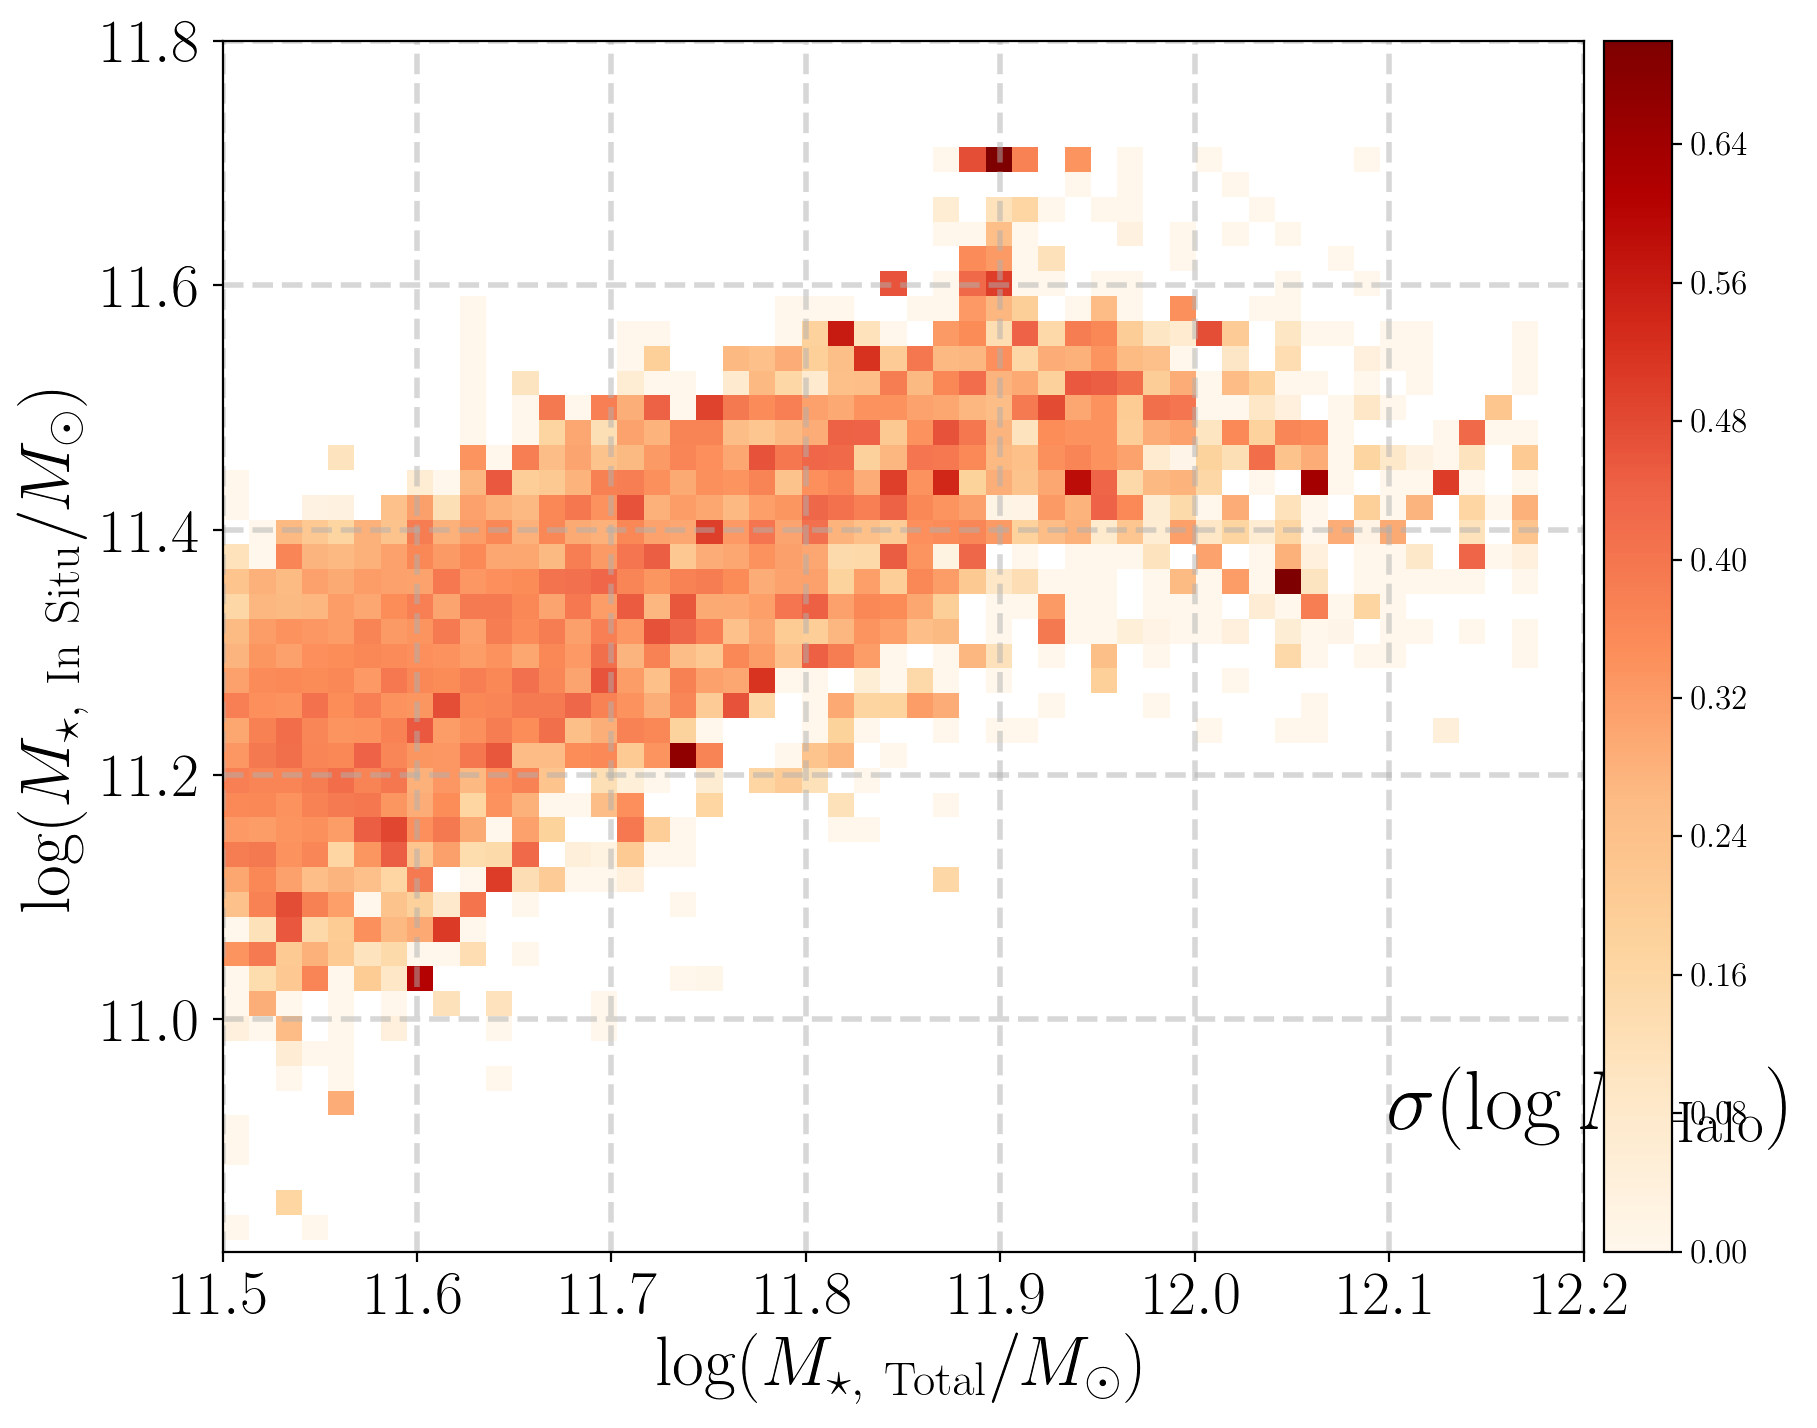

In [149]:
# --------------------------------------------------------------------------------------- #
xtickFormat='$\mathbf{%4.1f}$'
ytickFormat='$\mathbf{%4.1f}$'

ORG = plotting.ORG
BLK = plotting.BLK

nColors = 30
nTicks = 10

# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

HM = ax1.imshow(zz_sigma.T, origin='lower',
                extent=[xedges[0], xedges[-1], 
                        yedges[0], yedges[-1]],
                aspect='auto', interpolation='nearest', 
                cmap=ORG, vmax=0.7)

ax1.set_xlabel('$\log (M_{\star,\ \mathrm{Total}}/M_{\odot})$', size=25)
ax1.set_ylabel('$\log (M_{\star,\ \mathrm{In\ Situ}}/M_{\odot})$', size=25)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
    
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
cTicks = MaxNLocator(nTicks).tick_values(np.nanmin(zz_sigma),
                                         0.7)
cbar = plt.colorbar(HM, cax=cax, ticks=cTicks)
cbar.solids.set_edgecolor("face") 

ax1.text(12.1, 10.9, r'$\sigma(\log M_{\mathrm{Halo}})$', size=30)

# --------------------------------------------------------------------------------------- #
## X, Y limits
ax1.set_xlim(um_test.obs_smf_tot_min, um_test.obs_smf_tot_max)
ax1.set_ylim(10.81, um_test.obs_smf_inn_max)

#### Running `simple` model

In [14]:
um_test = InsituExsituModel(model_type='simple', 
                            um_mtot_nbin=100,
                            mcmc_nsamples=20, 
                            mcmc_nburnin=10, 
                            mcmc_nwalkers=100)

um_test.mcmcFit()

# Input stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Input weak lensing profile sample: s16a_wide2_massive_boxbin1
# There are 17 weak lensing profiles in this sample
# Pre-computed SMF for inner logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_11.5.fits
# Pre-computed SMF for total logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m100_11.5.fits
# Pre-computed full SMF: s82_total_smf_z0.15_0.43.fits
# The volume of the HSC data is    102060083.62 Mpc^3
# Using logm_10 as inner stellar mass.
# Using logm_100 as total stellar mass.
# For inner stellar mass: 
    10 bins at 10.80 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.50 < logMtot < 12.20
# The volume of the UniverseMachine mock is    205348196.23 Mpc^3
# Setup the sampler ...
# Setup the initial guesses ...
# Phase: Burn-in ...
# Phase: MCMC run ...
# Get MCMC samples and best-fit parameters ...
#------------------------------------------------------
#  Mean acc

### Test of `frac1` model 

* Constant fractions for both in-situ and ex-situ components

In [11]:
um_test = InsituExsituModel(model_type='frac1', 
                            um_mtot_nbin=90,
                            obs_wl_sample='s16a_wide2_massive_boxbin1',
                            mcmc_wl_weight=0.2)

frac_ins, frac_exs = 0.75998, 0.07878
param_frac1 = (0.71, 3.4, -0.095, 1.18621, frac_ins, frac_exs)

um_mass_predicted = um_test.umPredictMass(param_frac1, 
                                          constant_bin=False)

logms_inn_mod, logms_tot_mod, logms_halo_mod, mask_tot, um_mock_use = um_mass_predicted

# Input stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Input weak lensing profile sample: s16a_wide2_massive_boxbin1
# There are 17 weak lensing profiles in this sample
# Pre-computed SMF for inner logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_11.5.fits
# Pre-computed SMF for total logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m100_11.5.fits
# Pre-computed full SMF: s82_total_smf_z0.15_0.43.fits
# The volume of the HSC data is    102060083.62 Mpc^3
# Using logm_10 as inner stellar mass.
# Using logm_100 as total stellar mass.
# For inner stellar mass: 
    10 bins at 10.80 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.50 < logMtot < 12.20
# The volume of the UniverseMachine mock is    205348196.23 Mpc^3


In [12]:
%timeit um_mod_predicted = um_test.umPredictModel(param_frac1, constant_bin=False)

1 loop, best of 3: 917 ms per loop


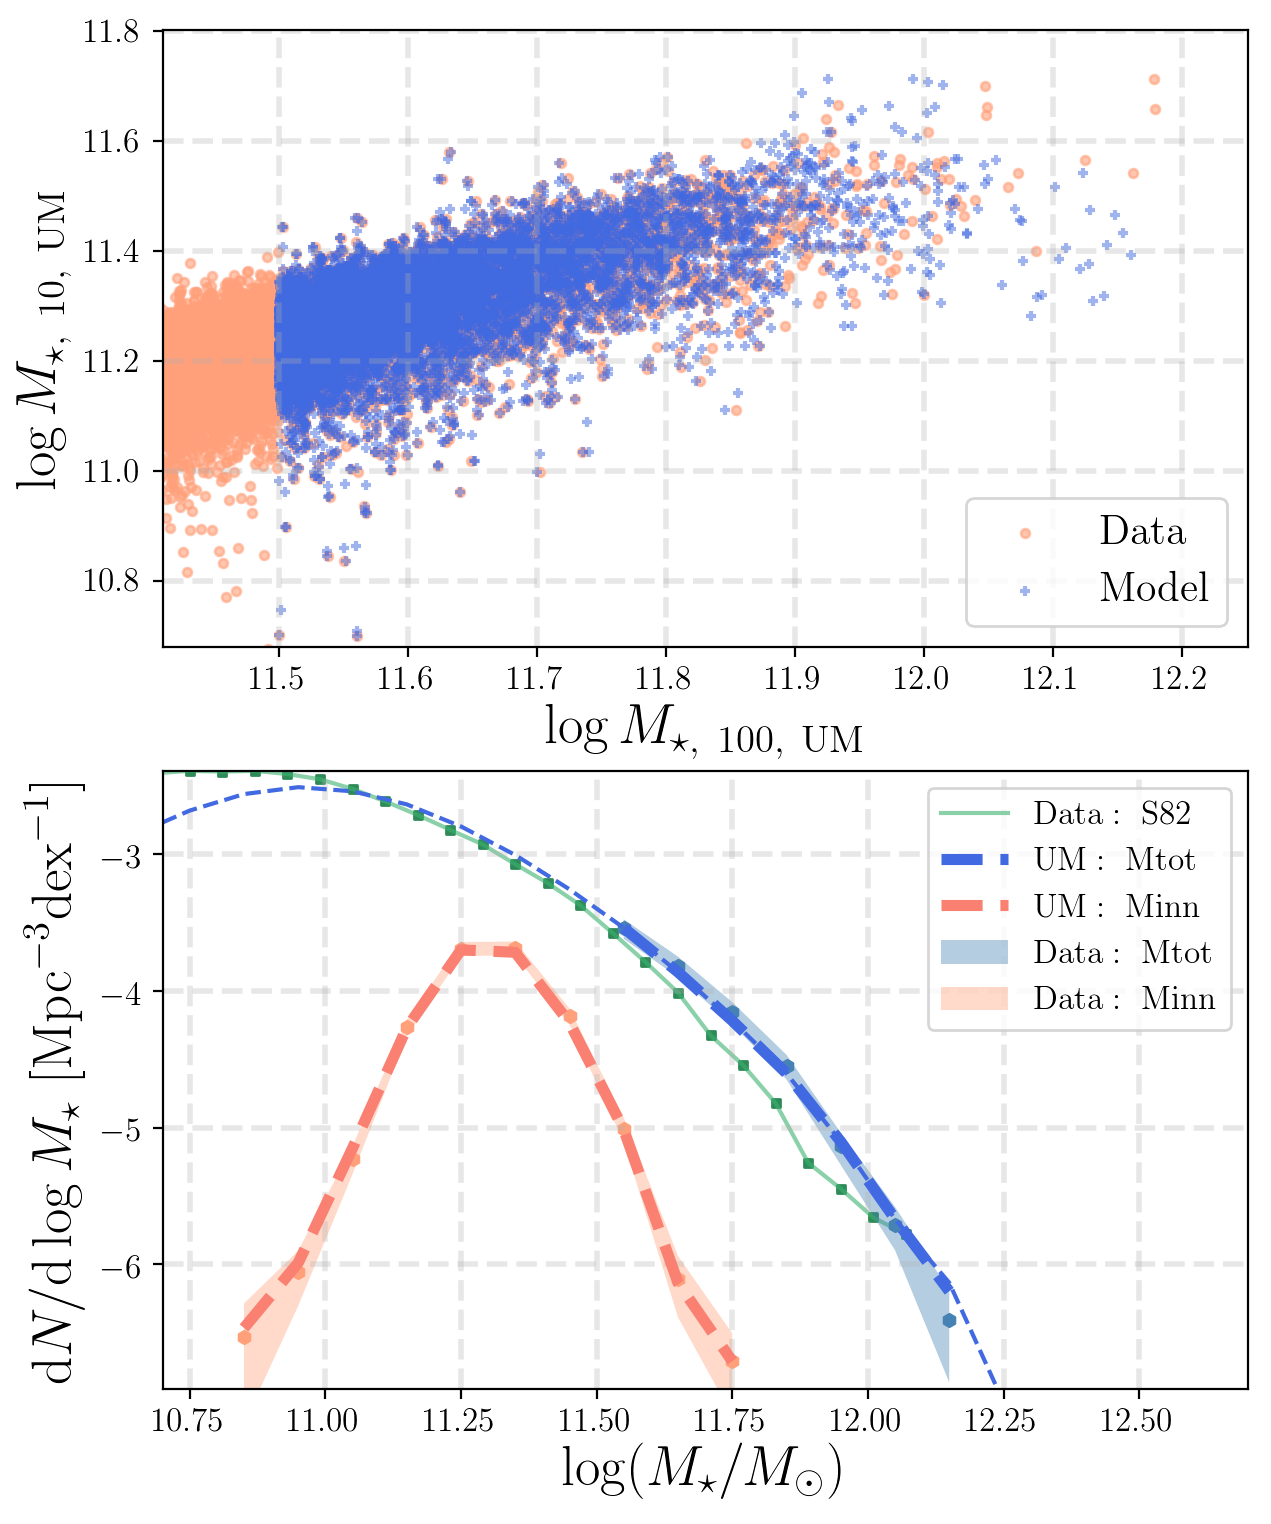

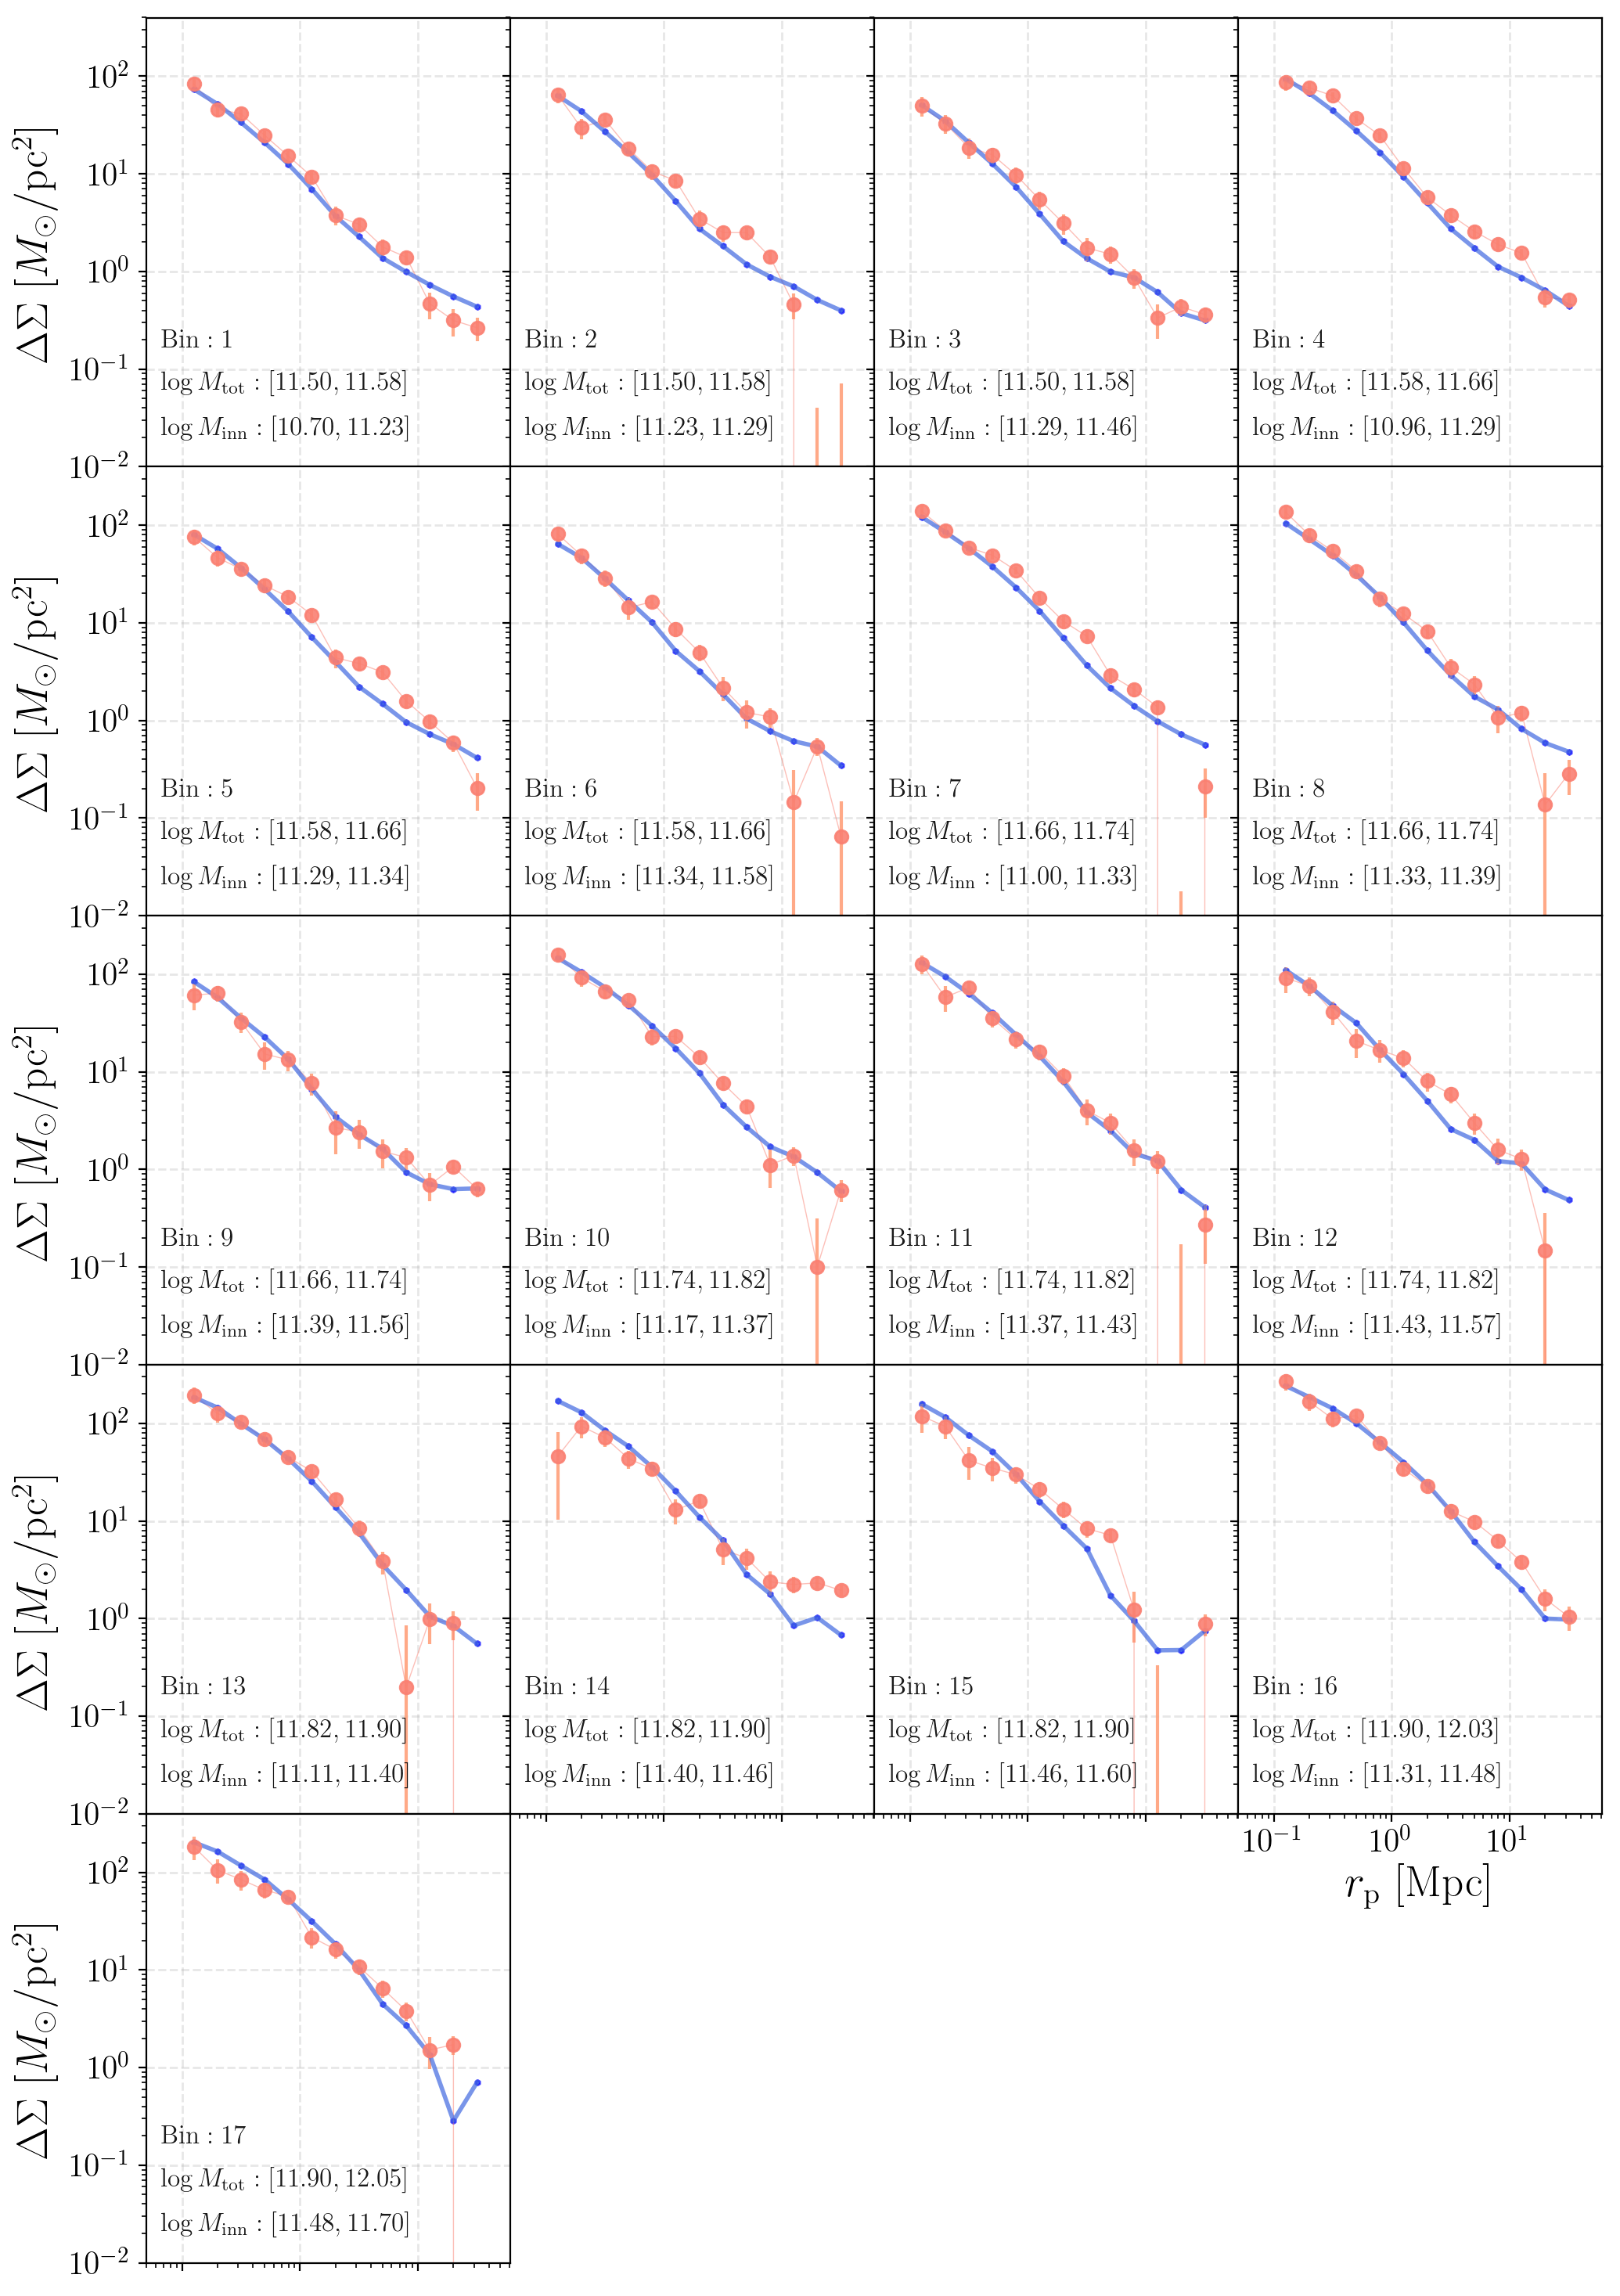

In [46]:
#frac_ins, frac_exs = 0.80973, 0.12520
#param_frac1 = (0.6125, 3.5365, -0.088, 0.8154, frac_ins, frac_exs)
frac_ins, frac_exs = 0.80973, 0.12520
param_frac1 = (0.6025, 3.625, -0.0528, 0.8154, frac_ins, frac_exs)

um_mod_predicted = um_test.umPredictModel(param_frac1, 
                                          plotSMF=True, 
                                          plotWL=True,
                                          constant_bin=False)

(um_smf_tot, um_smf_inn, um_wl_profs, 
 logms_inn_mod, logms_tot_mod, logms_halo_mod, 
 mask_tot, um_mock_use) = um_mod_predicted

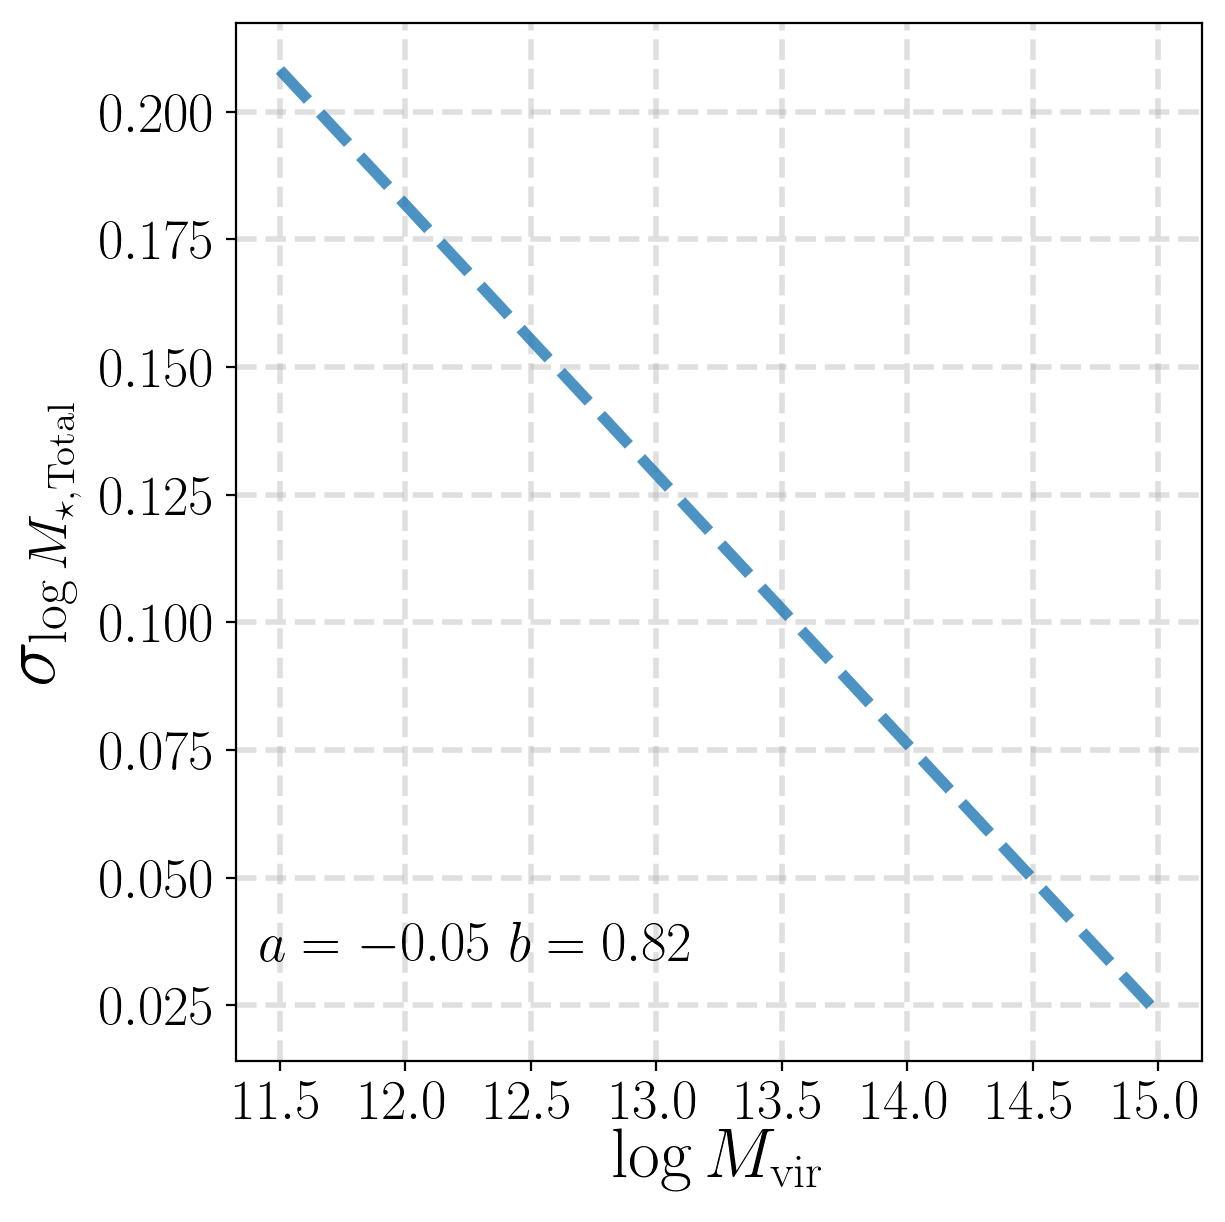

In [37]:
sigms_fig = plot_best_fit_scatter_relation(-0.0528, 0.8154, min_scatter=0.02)

#### Test running `frac1` model

In [37]:
%timeit um_test.lnLike(param_frac1)

1 loop, best of 3: 285 ms per loop


In [198]:
um_test = InsituExsituModel(model_type='frac1',
                            um_mtot_nbin=100,
                            um_min_nobj_per_bin=15,
                            mcmc_wl_weight=0.5,
                            mcmc_smf_only=True,
                            mcmc_nsamples=100, 
                            mcmc_nburnin=50, 
                            mcmc_nwalkers=100)

# Input stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Input weak lensing profile sample: s16a_wide2_massive_boxbin3
# There are 15 weak lensing profiles in this sample
# Pre-computed SMF for inner logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_11.5.fits
# Pre-computed SMF for total logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m100_11.5.fits
# Pre-computed full SMF: s82_total_smf_z0.15_0.43.fits
# The volume of the HSC data is    102060083.62 Mpc^3
# Using logm_10 as inner stellar mass.
# Using logm_100 as total stellar mass.
# For inner stellar mass: 
    10 bins at 10.80 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.50 < logMtot < 12.20
# The volume of the UniverseMachine mock is    205348196.23 Mpc^3


In [199]:
%timeit um_test.lnLike(param_frac1)

1 loop, best of 3: 309 ms per loop


78.0593846551


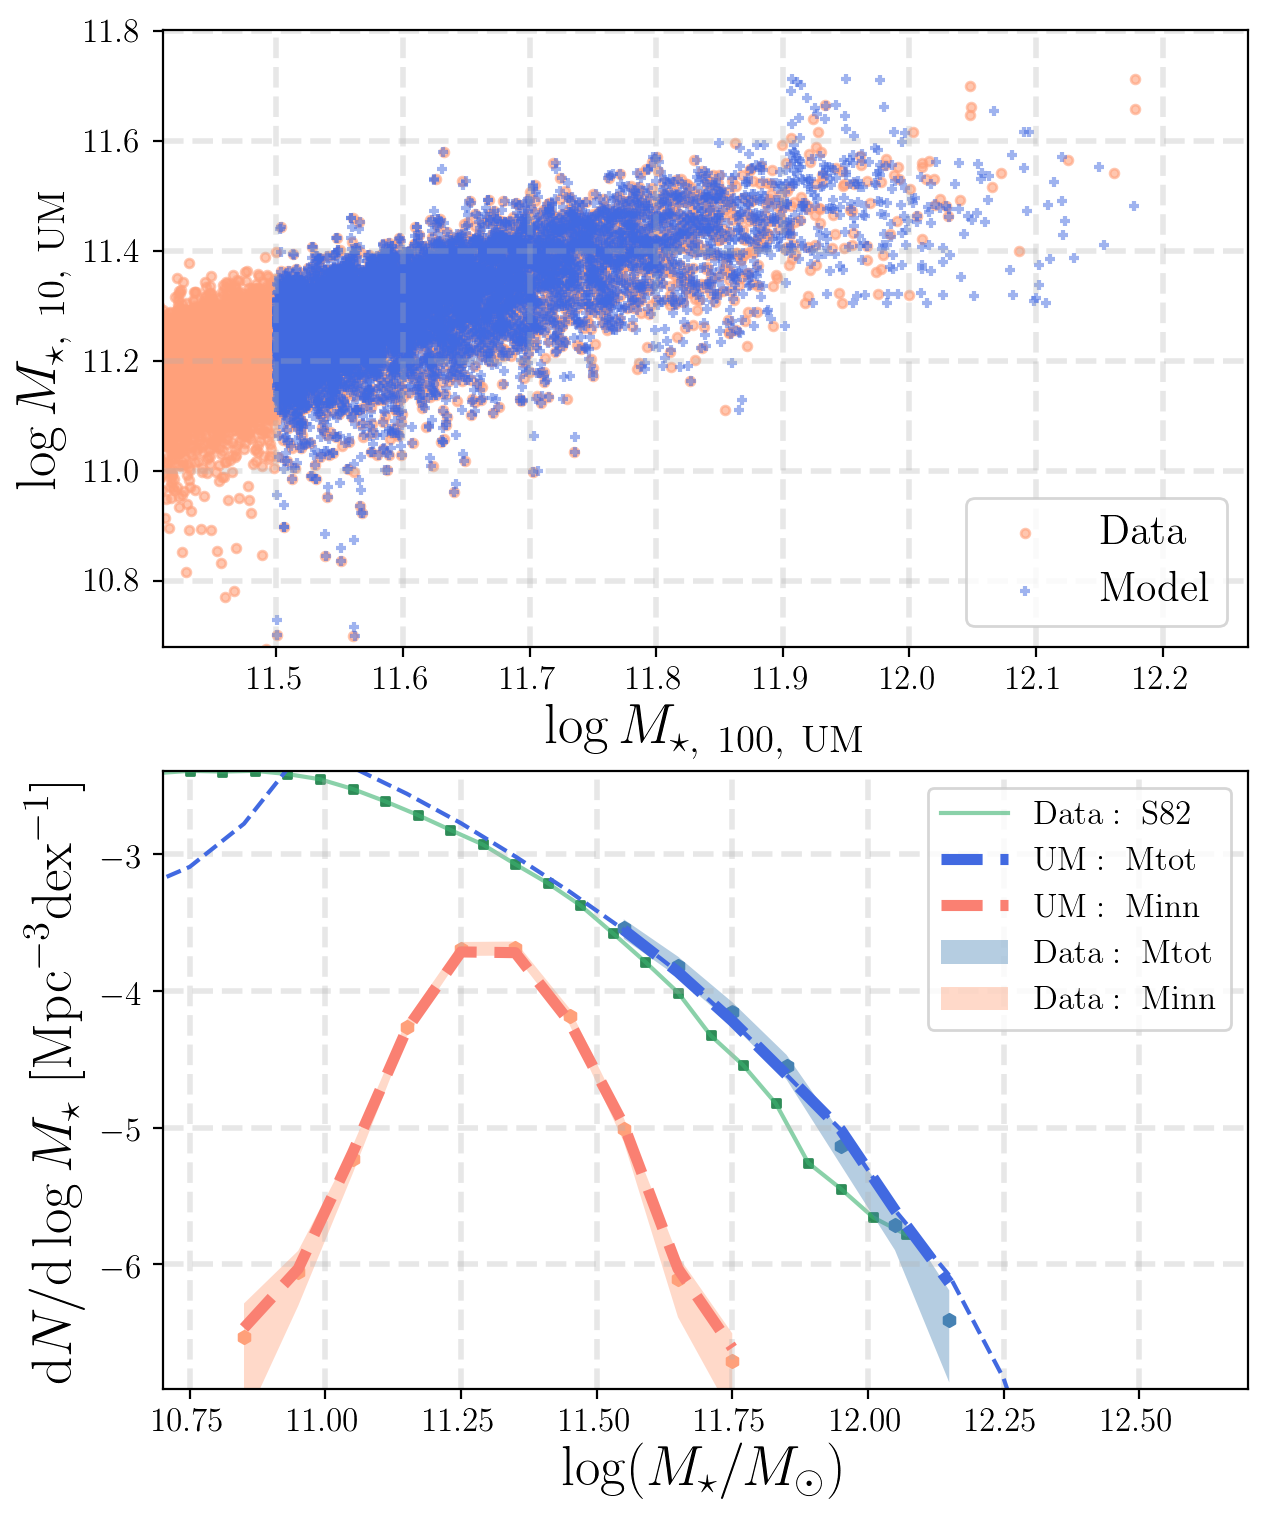

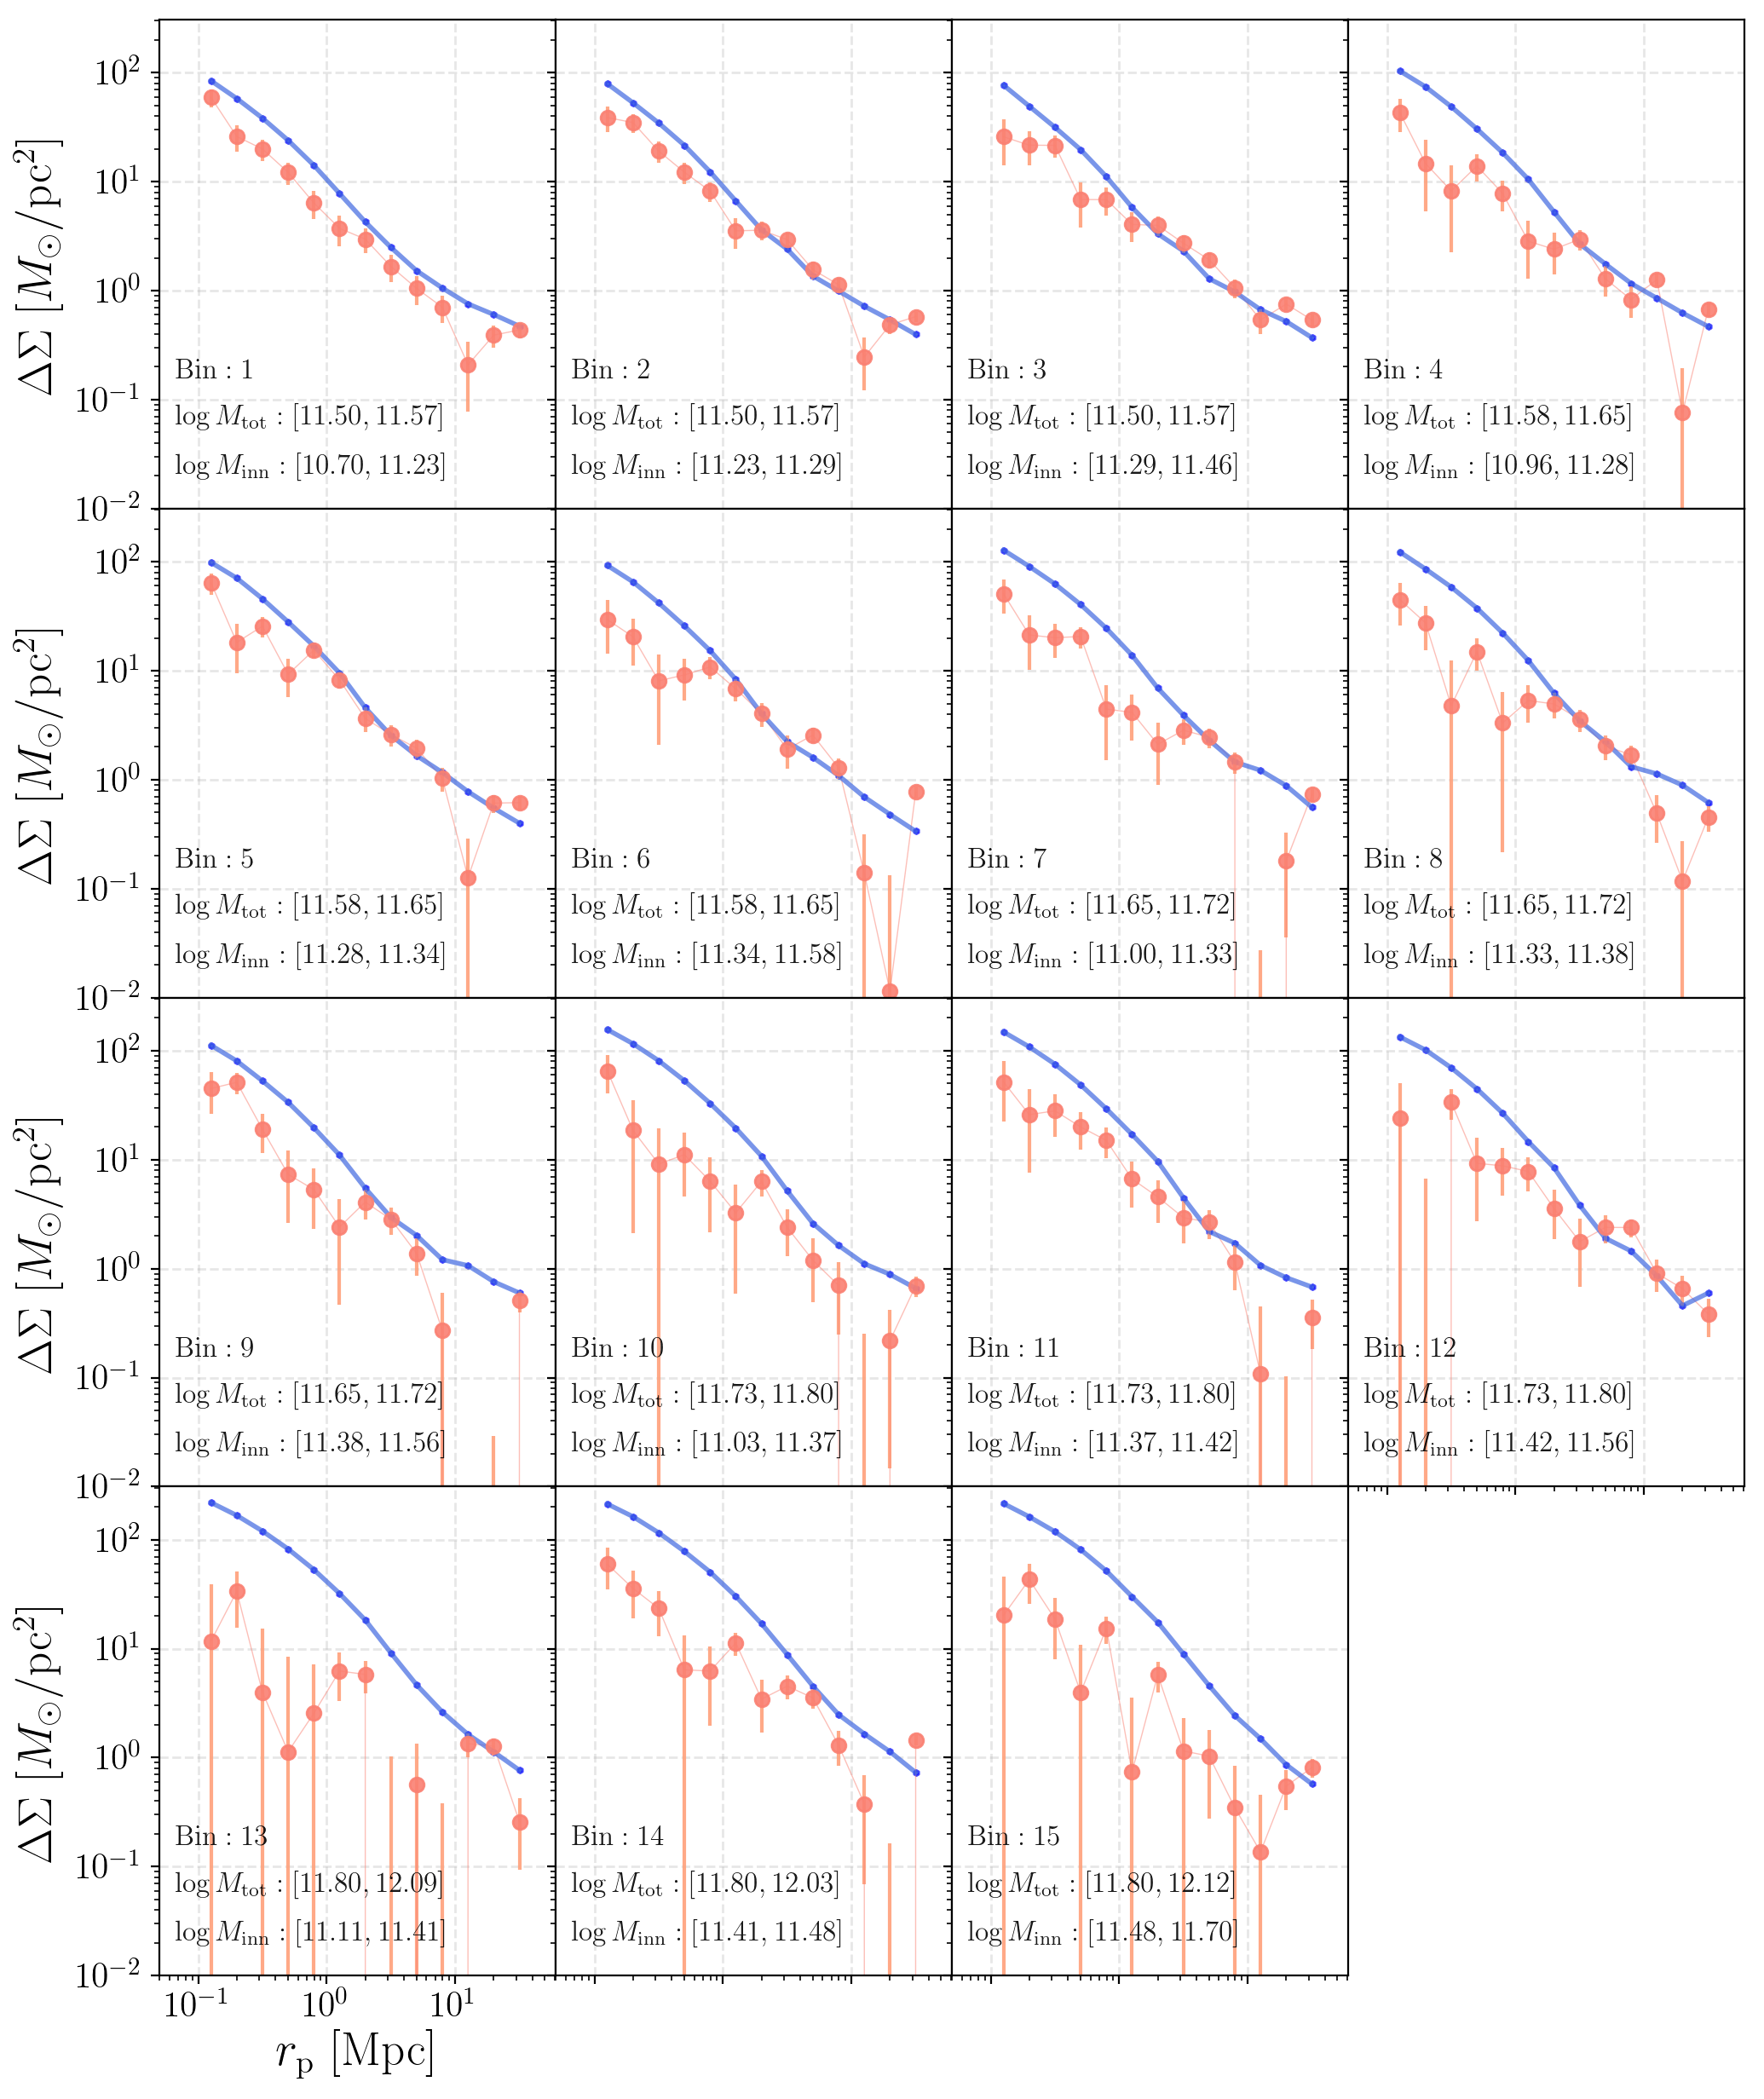

In [236]:
#param_frac1 = np.asarray(um_test.mcmc_params_stats)[:, 0]
param_frac1 = [0.5901, 3.8482, -0.095, 0.80, 0.9, 0.1]

print(um_test.lnLike(param_frac1))

um_mod_predicted = um_test.umPredictModel(param_frac1, 
                                          plotSMF=True, 
                                          plotWL=True,
                                          constant_bin=False)

(um_smf_tot, um_smf_inn, um_wl_profs, 
 logms_inn_mod, logms_tot_mod, logms_halo_mod, 
 mask_tot, um_mock_use) = um_mod_predicted

In [48]:
xx = logms_tot_mod
yy = logms_inn_mod
zz = um_mock_use['logmh_vir']

xMin, xMax = np.nanmin(xx), np.nanmax(xx)
yMin, yMax = np.nanmin(yy), np.nanmax(yy)
zMin, zMax = np.nanmin(zz), np.nanmax(zz)

zz_count, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                               'count', 
                                               bins=50)

zz_median, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                                np.nanmedian, 
                                                bins=50)

zz_sigma, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                               np.nanstd, 
                                               bins=50)
xcen = (xedges[0:-2] + xedges[1:-1]) / 2
ycen = (yedges[0:-2] + yedges[1:-1]) / 2

/usr/local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:990: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


(10.81, 11.800000000000001)

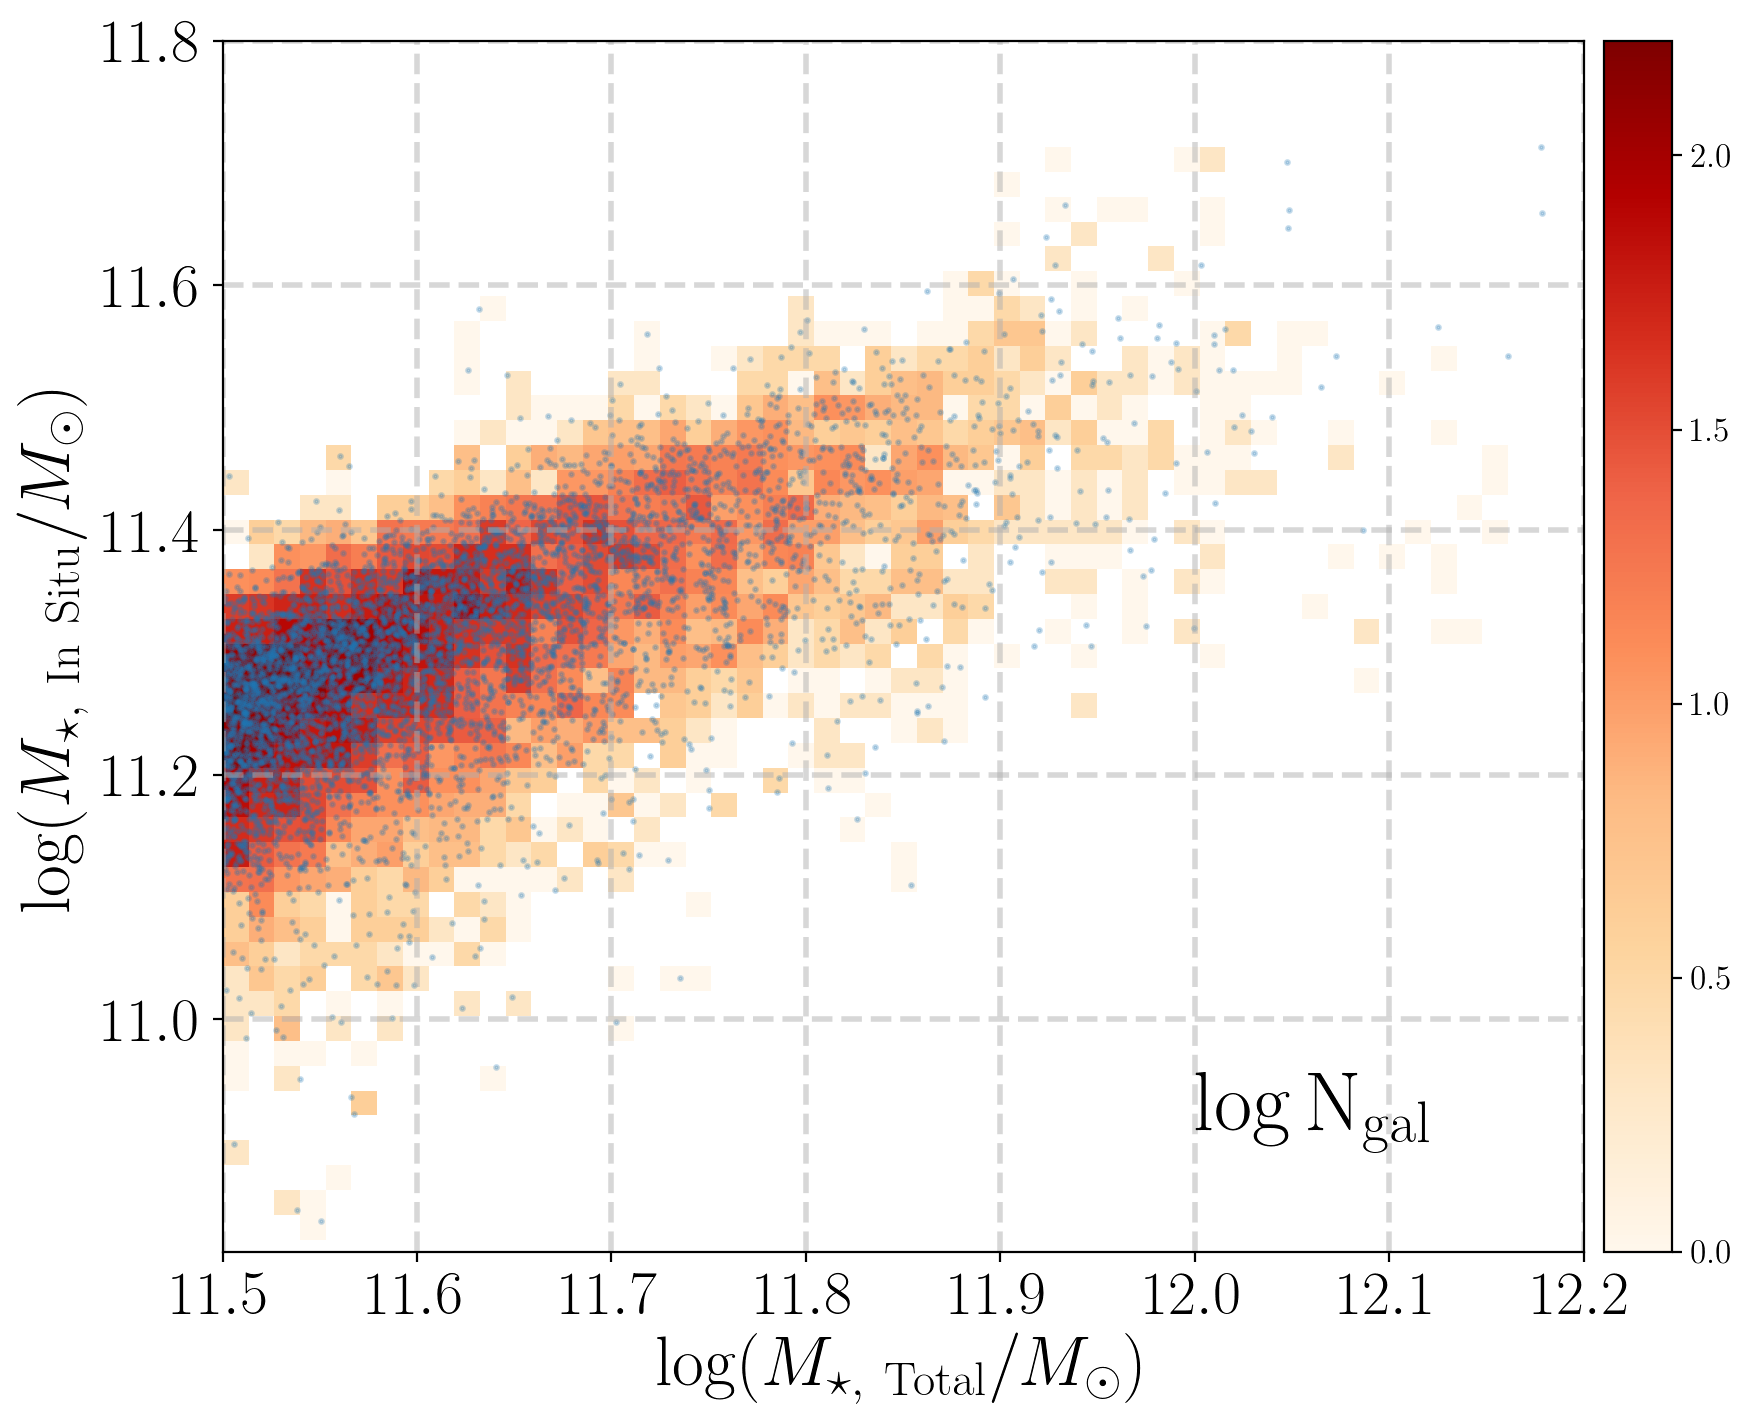

In [49]:
# --------------------------------------------------------------------------------------- #
xtickFormat='$\mathbf{%4.1f}$'
ytickFormat='$\mathbf{%4.1f}$'

ORG = plotting.ORG
BLK = plotting.BLK

nColors = 30
nTicks = 10


# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

HM = ax1.imshow(np.log10(zz_count.T), origin='lower',
                extent=[xedges[0], xedges[-1], 
                        yedges[0], yedges[-1]],
                aspect='auto', interpolation='nearest', 
                cmap=ORG)

ax1.set_xlabel('$\log (M_{\star,\ \mathrm{Total}}/M_{\odot})$', size=25)
ax1.set_ylabel('$\log (M_{\star,\ \mathrm{In\ Situ}}/M_{\odot})$', size=25)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
    
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
cTicks = MaxNLocator(nTicks).tick_values(0, 5)
cbar = plt.colorbar(HM, cax=cax, ticks=cTicks)
cbar.solids.set_edgecolor("face") 

ax1.scatter(um_test.obs_logms_tot,
            um_test.obs_logms_inn, s=2, alpha=0.25)

ax1.text(12.0, 10.9, r'$\log\mathrm{N_{gal}}$', size=30)

# --------------------------------------------------------------------------------------- #
## X, Y limits
ax1.set_xlim(um_test.obs_smf_tot_min, um_test.obs_smf_tot_max)
ax1.set_ylim(10.81, um_test.obs_smf_inn_max)

(10.81, 11.800000000000001)

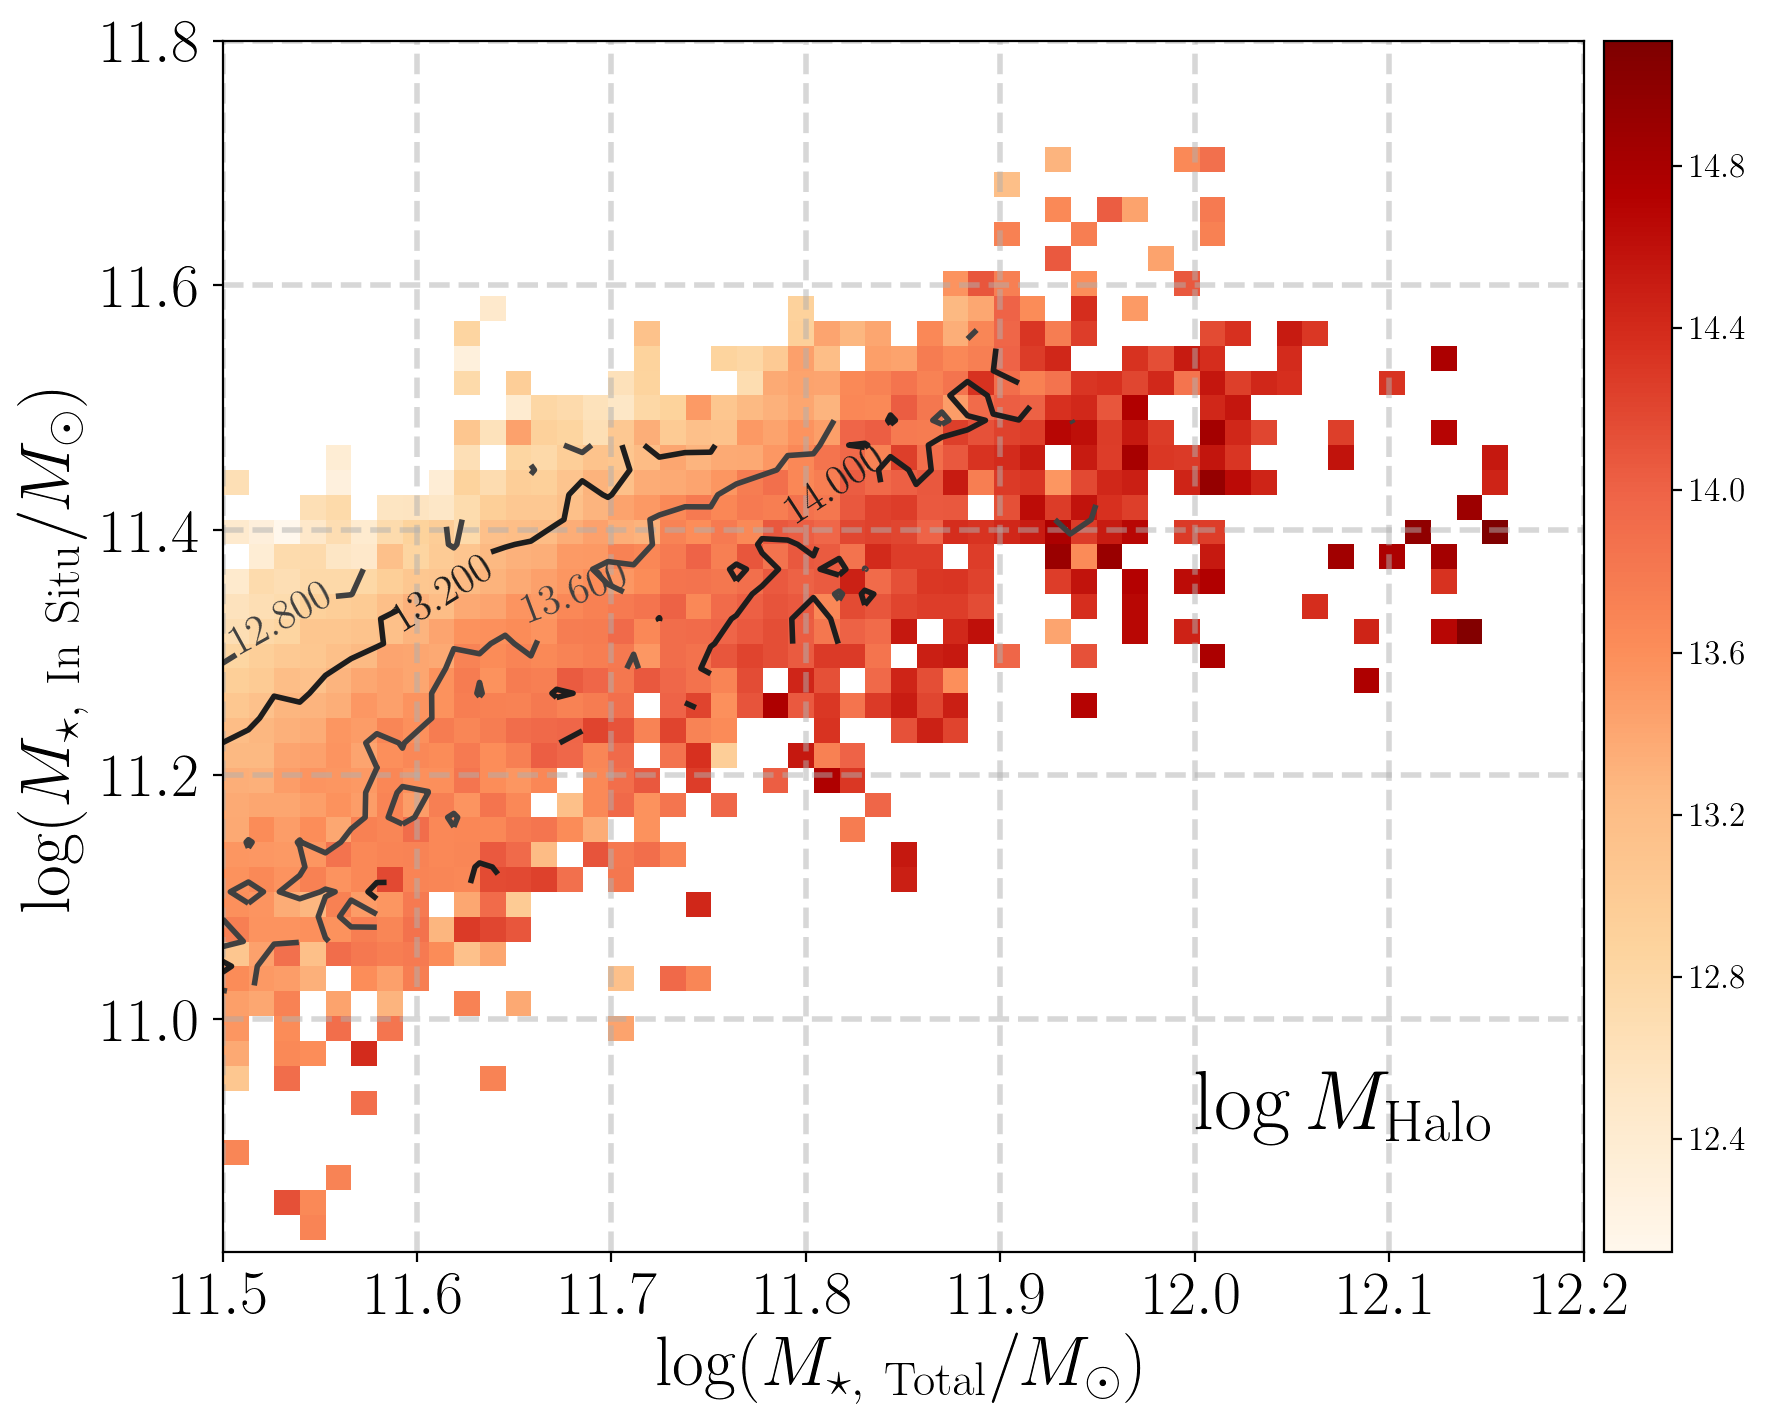

In [50]:
# --------------------------------------------------------------------------------------- #
xtickFormat='$\mathbf{%4.1f}$'
ytickFormat='$\mathbf{%4.1f}$'

ORG = plotting.ORG
BLK = plotting.BLK

nColors = 30
nTicks = 10

# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

HM = ax1.imshow(zz_median.T, origin='lower',
                extent=[xedges[0], xedges[-1], 
                        yedges[0], yedges[-1]],
                aspect='auto', interpolation='nearest', 
                cmap=ORG)

CT = ax1.contour(xedges[:-1], yedges[:-1], gaussian_filter(zz_median.T, 0.2), 
                 6, linewidths=2.0, 
                 colors=[BLK(0.8), BLK(0.9)], 
                 extend='neither')
ax1.clabel(CT, inline=1, fontsize=15)

ax1.set_xlabel('$\log (M_{\star,\ \mathrm{Total}}/M_{\odot})$', size=25)
ax1.set_ylabel('$\log (M_{\star,\ \mathrm{In\ Situ}}/M_{\odot})$', size=25)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
    
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
cTicks = MaxNLocator(nTicks).tick_values(zMin, zMax)
cbar = plt.colorbar(HM, cax=cax, ticks=cTicks)
cbar.solids.set_edgecolor("face") 

ax1.text(12.0, 10.9, r'$\log M_{\mathrm{Halo}}$', size=30)

# --------------------------------------------------------------------------------------- #
## X, Y limits
ax1.set_xlim(um_test.obs_smf_tot_min, um_test.obs_smf_tot_max)
ax1.set_ylim(10.81, um_test.obs_smf_inn_max)

(10.81, 11.800000000000001)

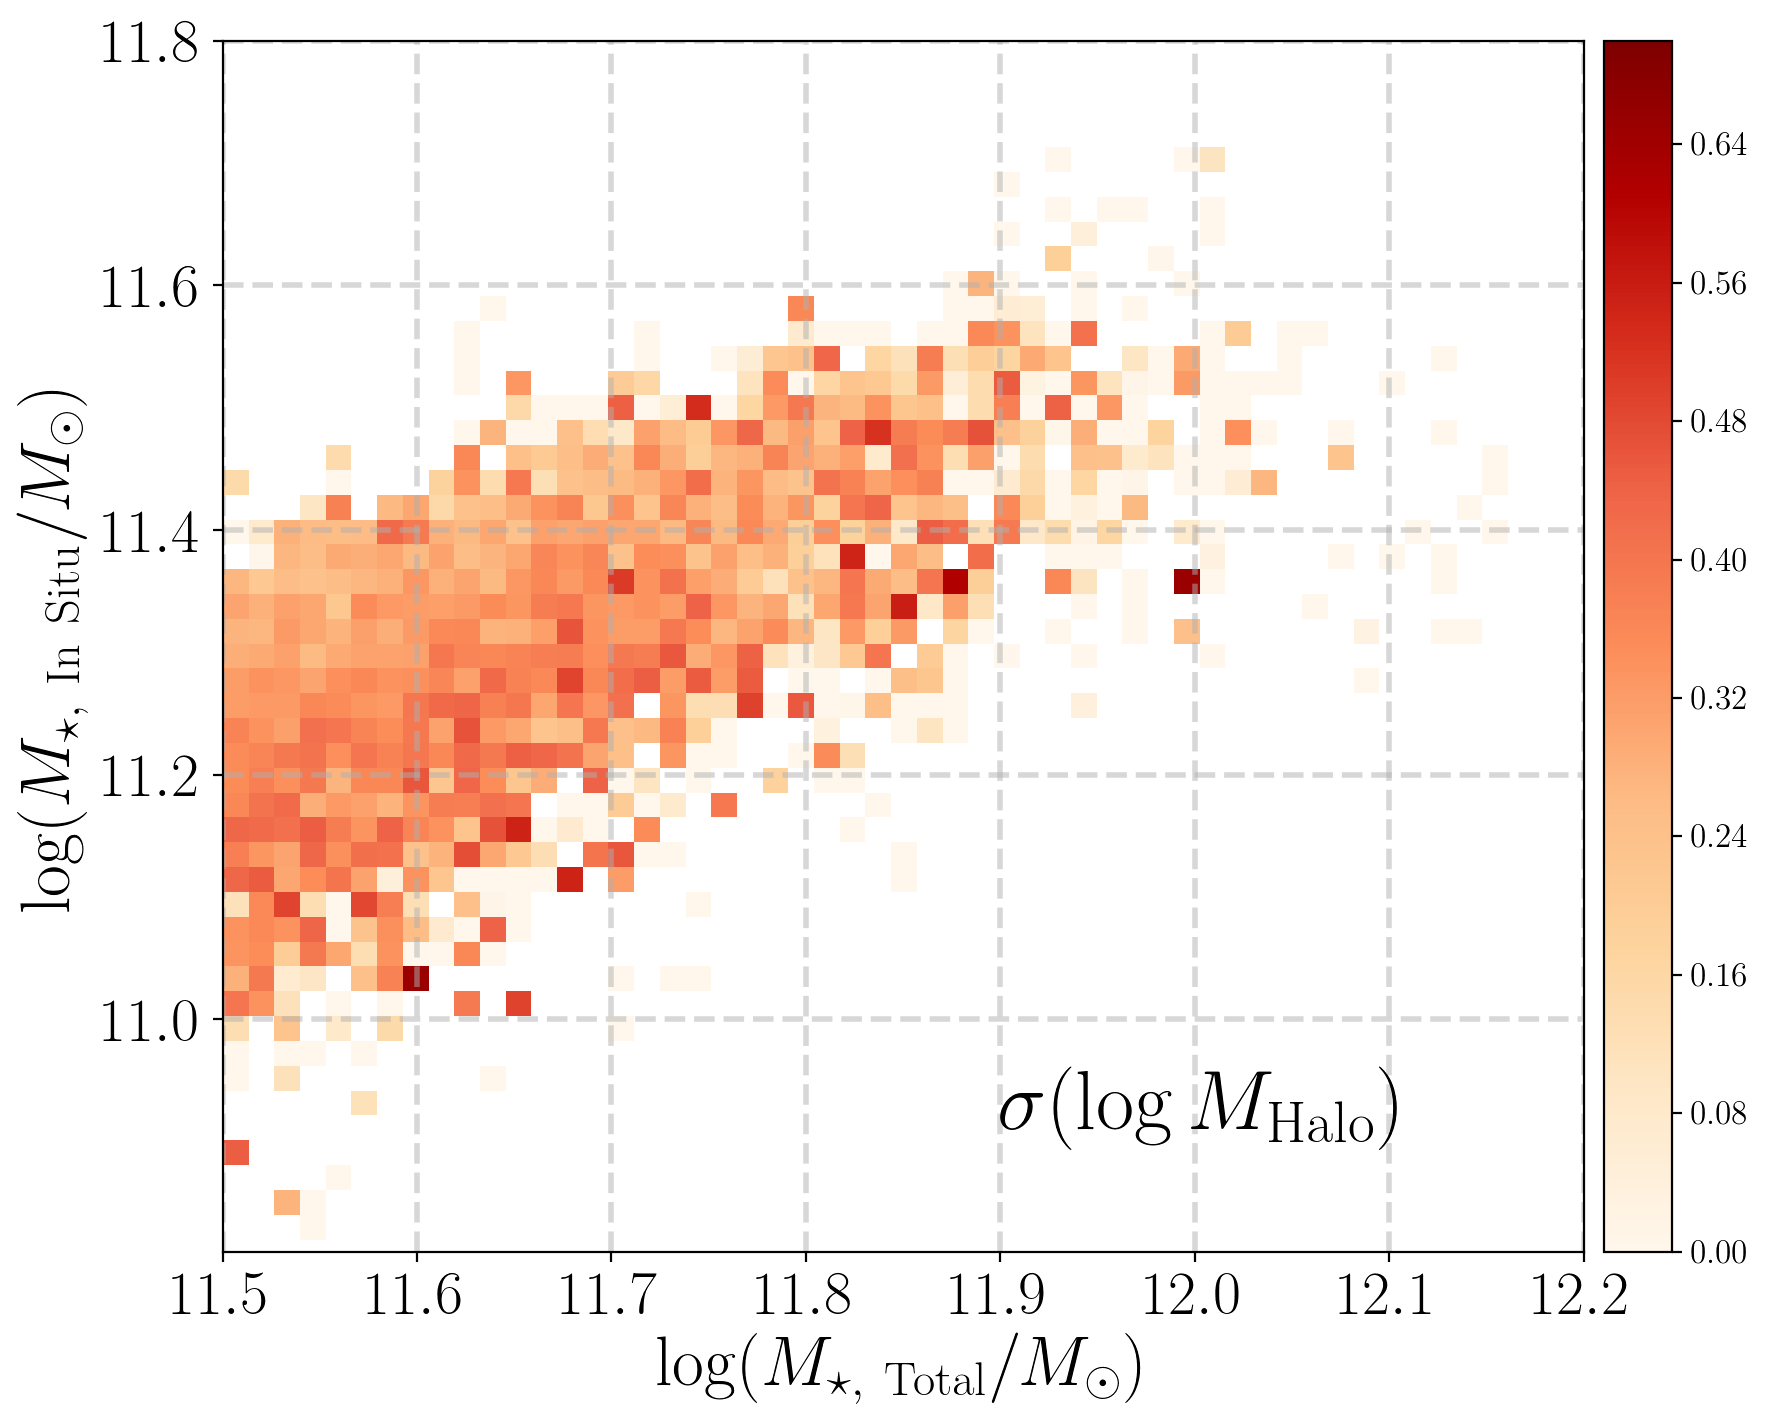

In [51]:
# --------------------------------------------------------------------------------------- #
xtickFormat='$\mathbf{%4.1f}$'
ytickFormat='$\mathbf{%4.1f}$'

ORG = plotting.ORG
BLK = plotting.BLK

nColors = 30
nTicks = 10

# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

HM = ax1.imshow(zz_sigma.T, origin='lower',
                extent=[xedges[0], xedges[-1], 
                        yedges[0], yedges[-1]],
                aspect='auto', interpolation='nearest', 
                cmap=ORG, vmax=0.7)

ax1.set_xlabel('$\log (M_{\star,\ \mathrm{Total}}/M_{\odot})$', size=25)
ax1.set_ylabel('$\log (M_{\star,\ \mathrm{In\ Situ}}/M_{\odot})$', size=25)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
    
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
cTicks = MaxNLocator(nTicks).tick_values(np.nanmin(zz_sigma),
                                         0.7)
cbar = plt.colorbar(HM, cax=cax, ticks=cTicks)
cbar.solids.set_edgecolor("face") 

ax1.text(11.9, 10.9, r'$\sigma(\log M_{\mathrm{Halo}})$', size=30)

# --------------------------------------------------------------------------------------- #
## X, Y limits
ax1.set_xlim(um_test.obs_smf_tot_min, um_test.obs_smf_tot_max)
ax1.set_ylim(10.81, um_test.obs_smf_inn_max)

#### SMF only fit

In [56]:
um_test = InsituExsituModel(model_type='frac1',
                            um_mtot_nbin=100,
                            um_min_nobj_per_bin=15,
                            mcmc_wl_weight=0.5,
                            mcmc_nsamples=300, 
                            mcmc_nburnin=200, 
                            mcmc_nwalkers=128,
                            mcmc_smf_only=True)

um_test.mcmcFit()

# Input stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Input weak lensing profile sample: s16a_wide2_massive_boxbin3
# There are 15 weak lensing profiles in this sample
# Pre-computed SMF for inner logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_11.5.fits
# Pre-computed SMF for total logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m100_11.5.fits
# Pre-computed full SMF: s82_total_smf_z0.15_0.43.fits
# The volume of the HSC data is    102060083.62 Mpc^3
# Using logm_10 as inner stellar mass.
# Using logm_100 as total stellar mass.
# For inner stellar mass: 
    10 bins at 10.80 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.50 < logMtot < 12.20
# The volume of the UniverseMachine mock is    205348196.23 Mpc^3
# Setup the sampler ...
# Setup the initial guesses ...
# Phase: Burn-in ...


/usr/local/lib/python2.7/site-packages/halotools/utils/inverse_transformation_sampling.py:177: UserWarning: The build_cdf_lookup function was called with the (optional) ``npts_lookup_table`` argument set to 1000.
However, the number of data points in your data table npts_y = 56.
The default behavior in this situation is to overwrite ``npts_lookup_table`` = ``npts_y``,
so that every point in the data set is used to build the lookup table.
  warn(warning_msg.format(npts_lookup_table, npts_y))
/usr/local/lib/python2.7/site-packages/halotools/utils/inverse_transformation_sampling.py:177: UserWarning: The build_cdf_lookup function was called with the (optional) ``npts_lookup_table`` argument set to 1000.
However, the number of data points in your data table npts_y = 93.
The default behavior in this situation is to overwrite ``npts_lookup_table`` = ``npts_y``,
so that every point in the data set is used to build the lookup table.
  warn(warning_msg.format(npts_lookup_table, npts_y))


# Phase: MCMC run ...
# Get MCMC samples and best-fit parameters ...
#------------------------------------------------------
#  Mean acceptance fraction 0.148125
#------------------------------------------------------
#  Best ln(Probability):    79.70881
[ 0.54147931  4.26417761 -0.07464899  1.21371288  0.63238651  0.11627967]
#------------------------------------------------------
(0.56886439968044211, 0.033961081946651372, 0.038577979522173678)
(4.1182063448517079, 0.40981780651358246, 0.35031143262318665)
(-0.099016647732267926, 0.055748194141482826, 0.069042509941468877)
(0.80720685509485612, 0.42226471053289227, 0.47494774004869122)
(0.74333873819394702, 0.18457349538895562, 0.25887995133750757)
(0.15475678897276576, 0.098158502293775957, 0.11383944165324143)
#------------------------------------------------------


[ 0.58781388  3.82237728 -0.05462217  0.84852447  0.93852582  0.22828976]
77.9976284216


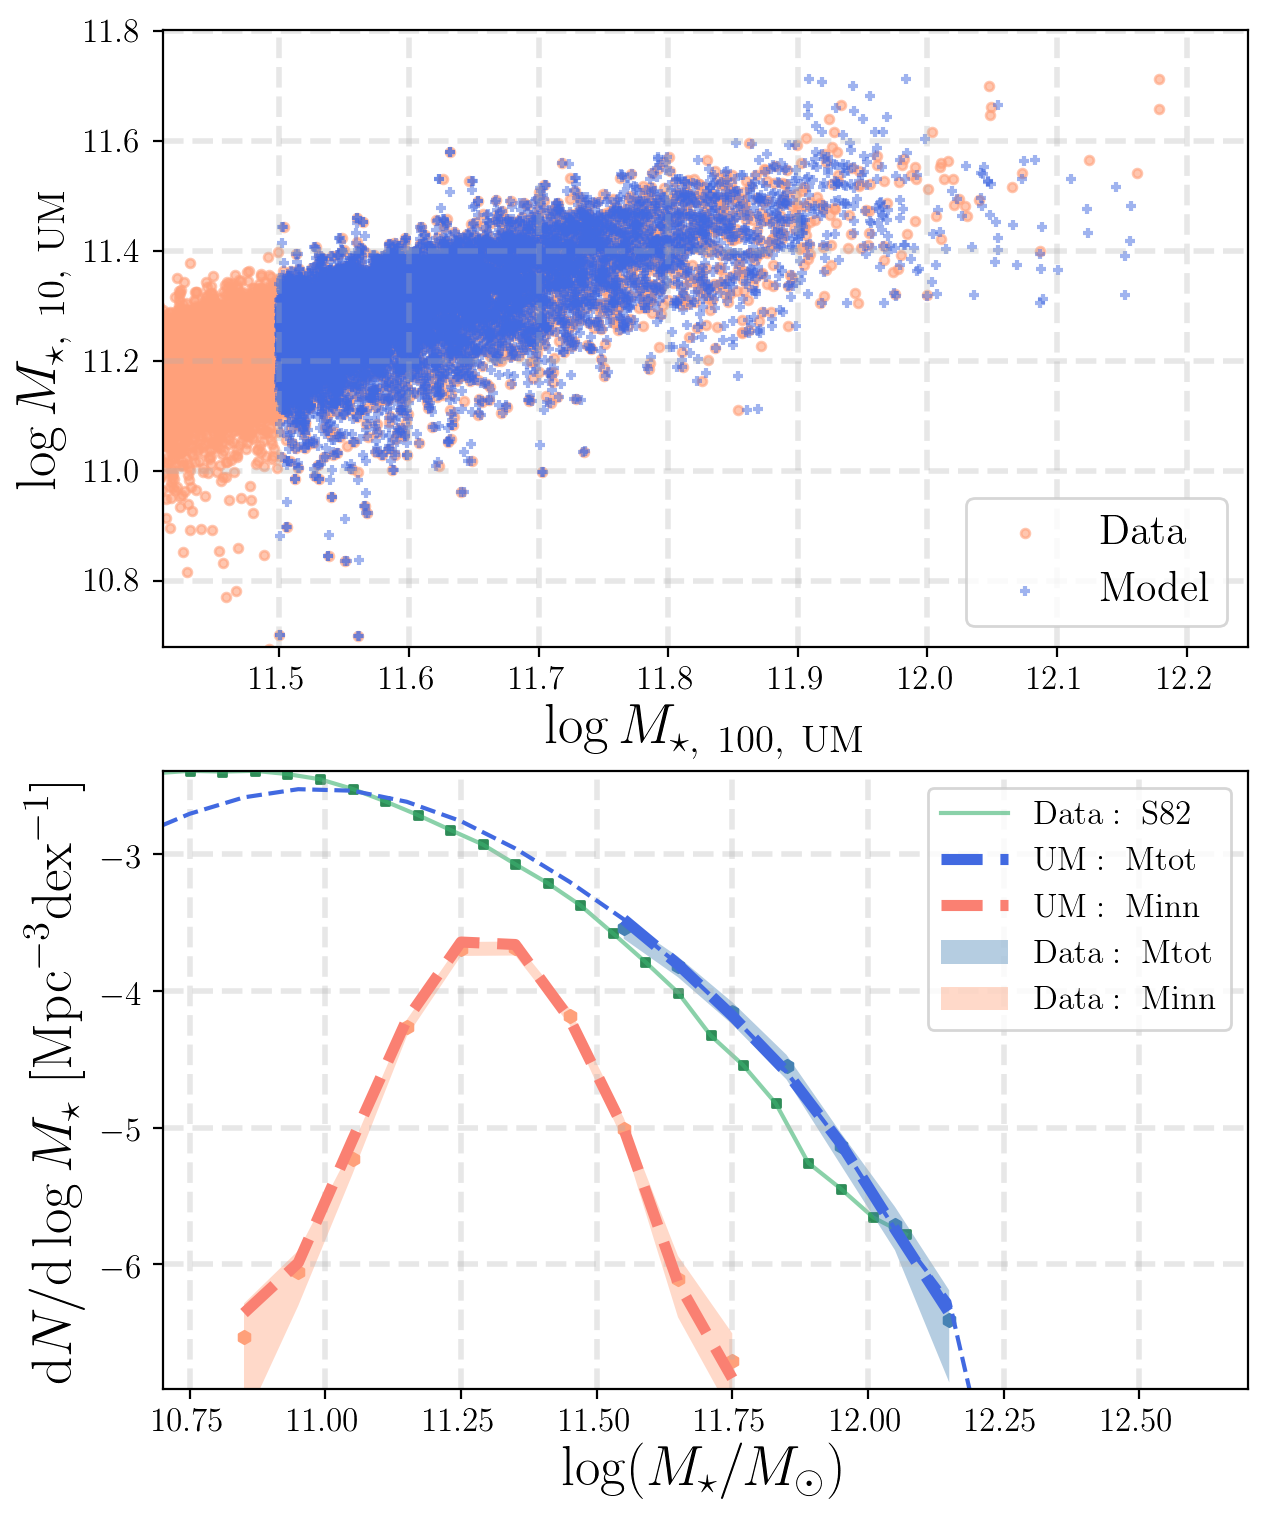

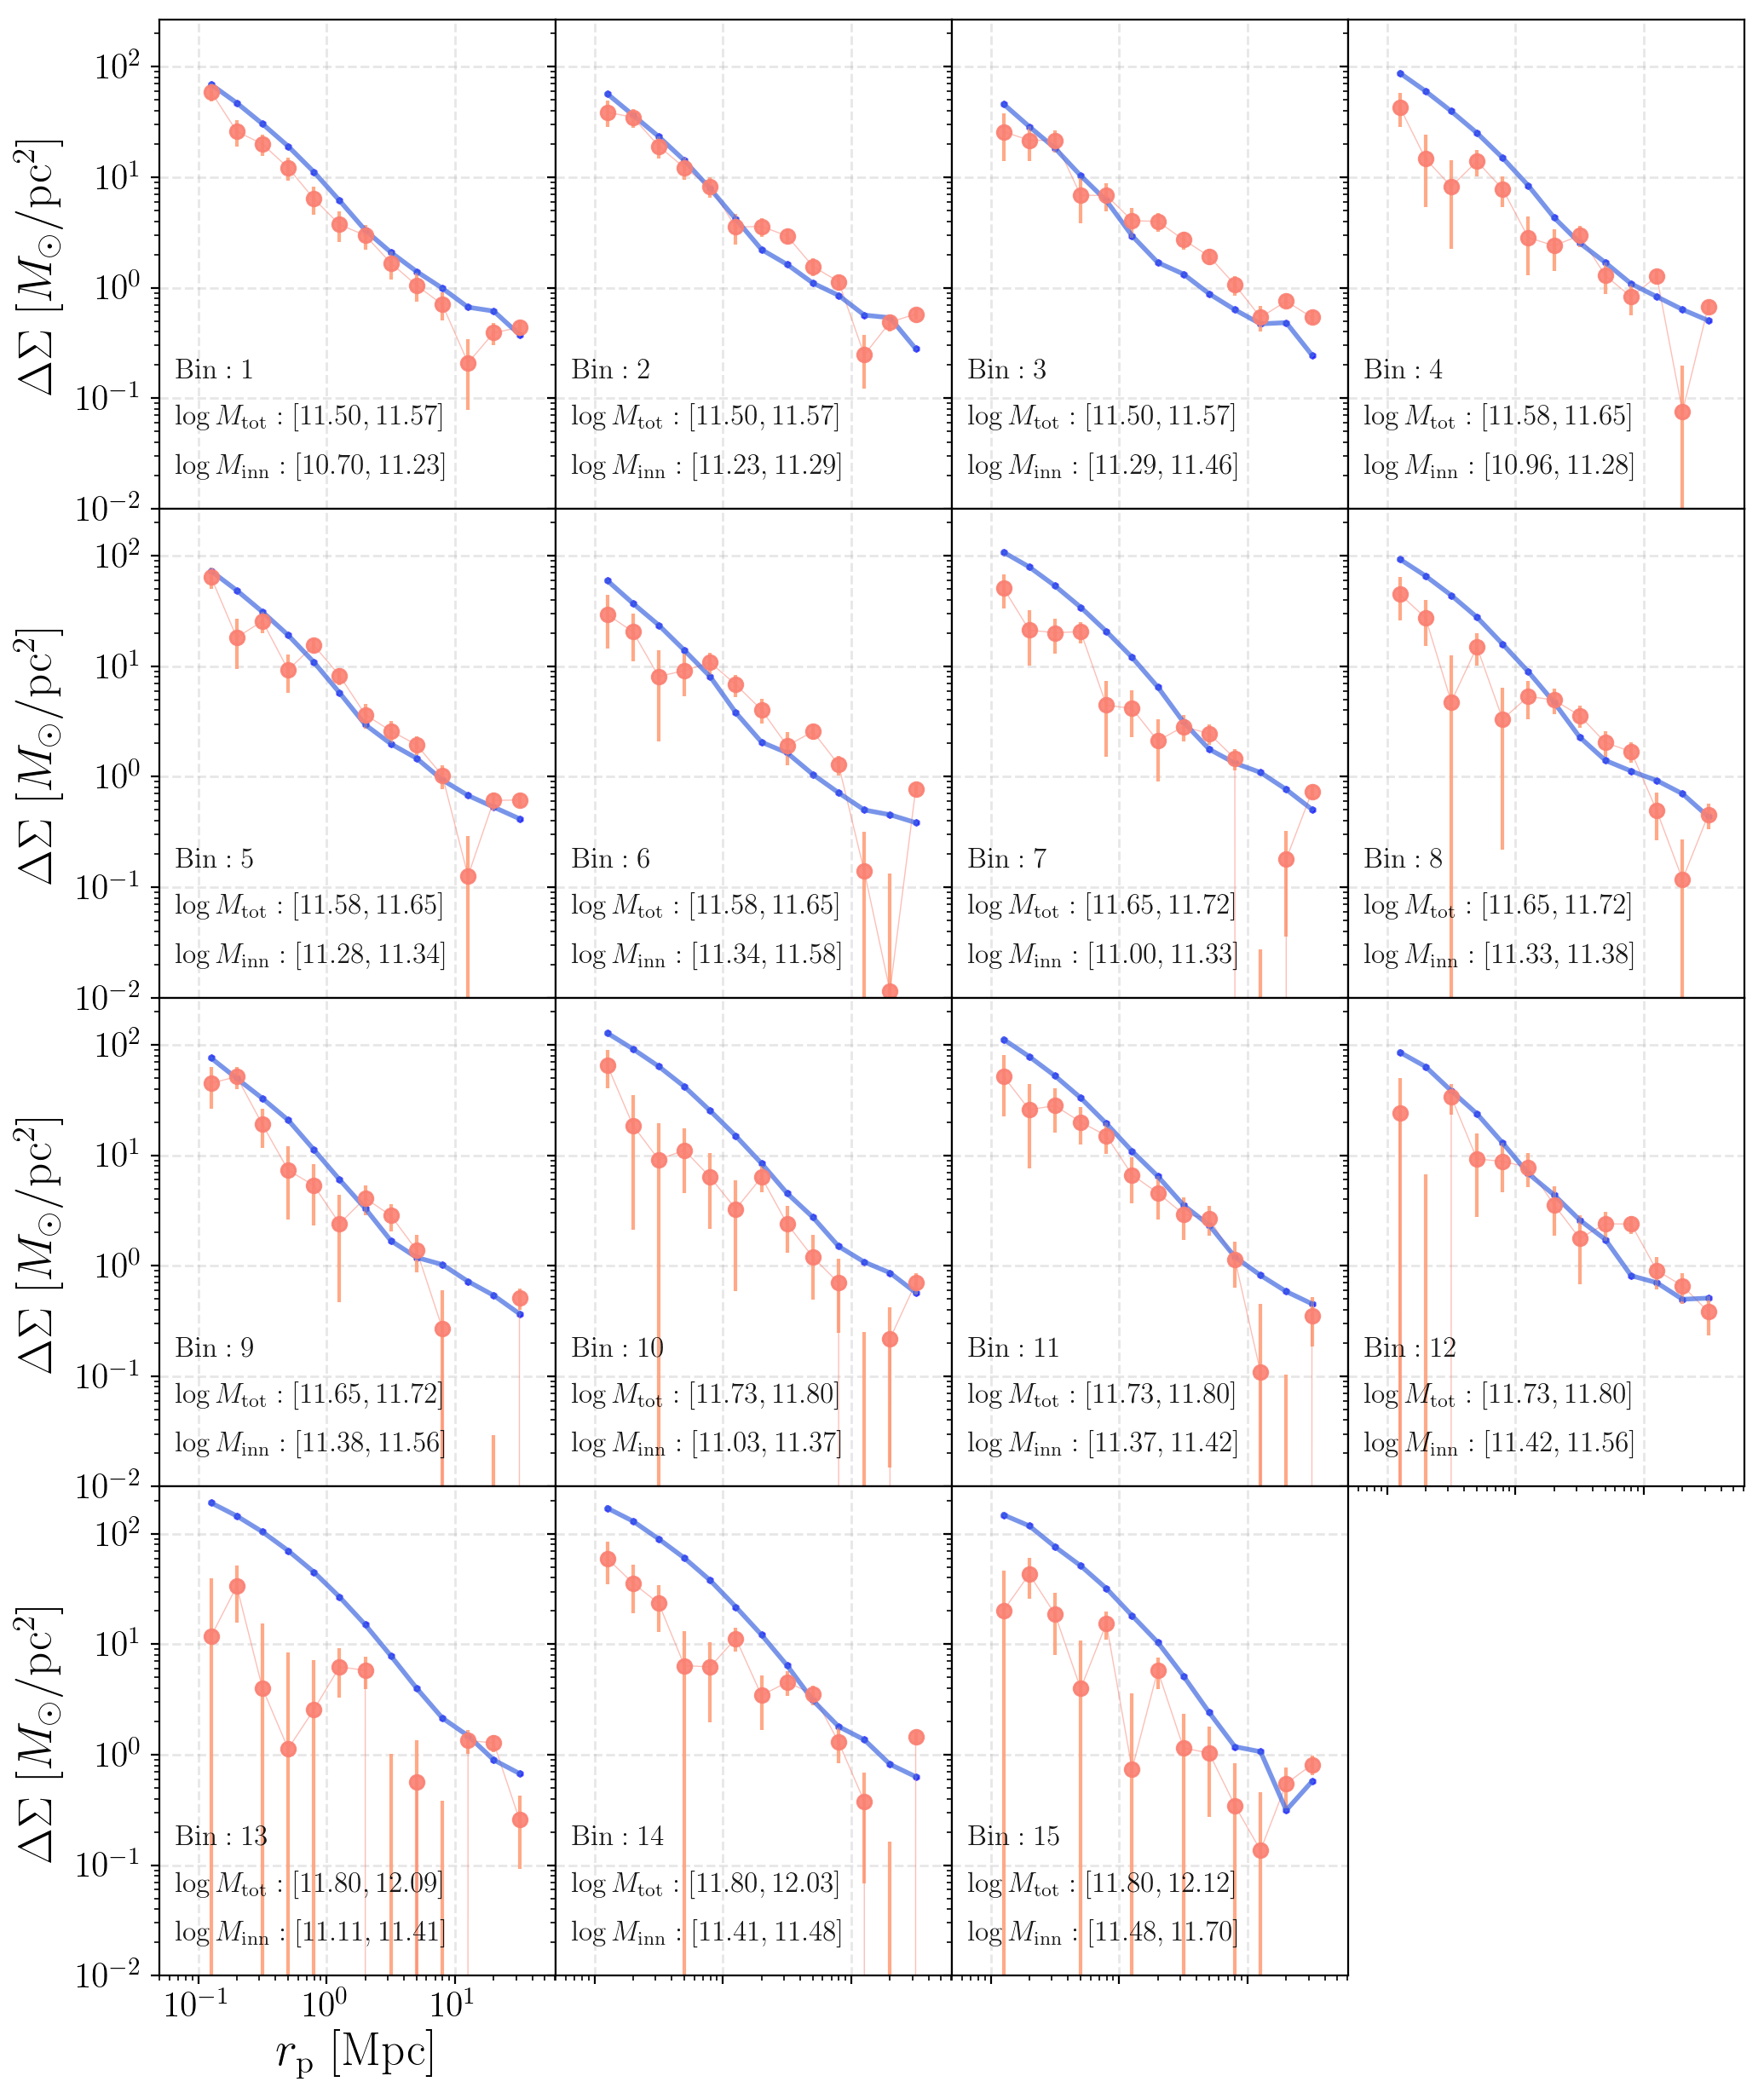

In [256]:
param_frac1 = (um_test.mcmc_samples[np.argmax(um_test.mcmc_lnprob)])
print(param_frac1)

print(um_test.lnLike(param_frac1))

um_mod_predicted = um_test.umPredictModel(param_frac1, 
                                          plotSMF=True, 
                                          plotWL=True,
                                          constant_bin=False)

(um_smf_tot, um_smf_inn, um_wl_profs, 
 logms_inn_mod, logms_tot_mod, logms_halo_mod, 
 mask_tot, um_mock_use) = um_mod_predicted

In [253]:
xx = logms_tot_mod
yy = logms_inn_mod
zz = um_mock_use['logmh_vir']

xMin, xMax = np.nanmin(xx), np.nanmax(xx)
yMin, yMax = np.nanmin(yy), np.nanmax(yy)
zMin, zMax = np.nanmin(zz), np.nanmax(zz)

zz_count, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                               'count', 
                                               bins=50)

zz_median, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                                np.nanmedian, 
                                                bins=50)

zz_sigma, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                               np.nanstd, 
                                               bins=50)
xcen = (xedges[0:-2] + xedges[1:-1]) / 2
ycen = (yedges[0:-2] + yedges[1:-1]) / 2

(10.81, 11.800000000000001)

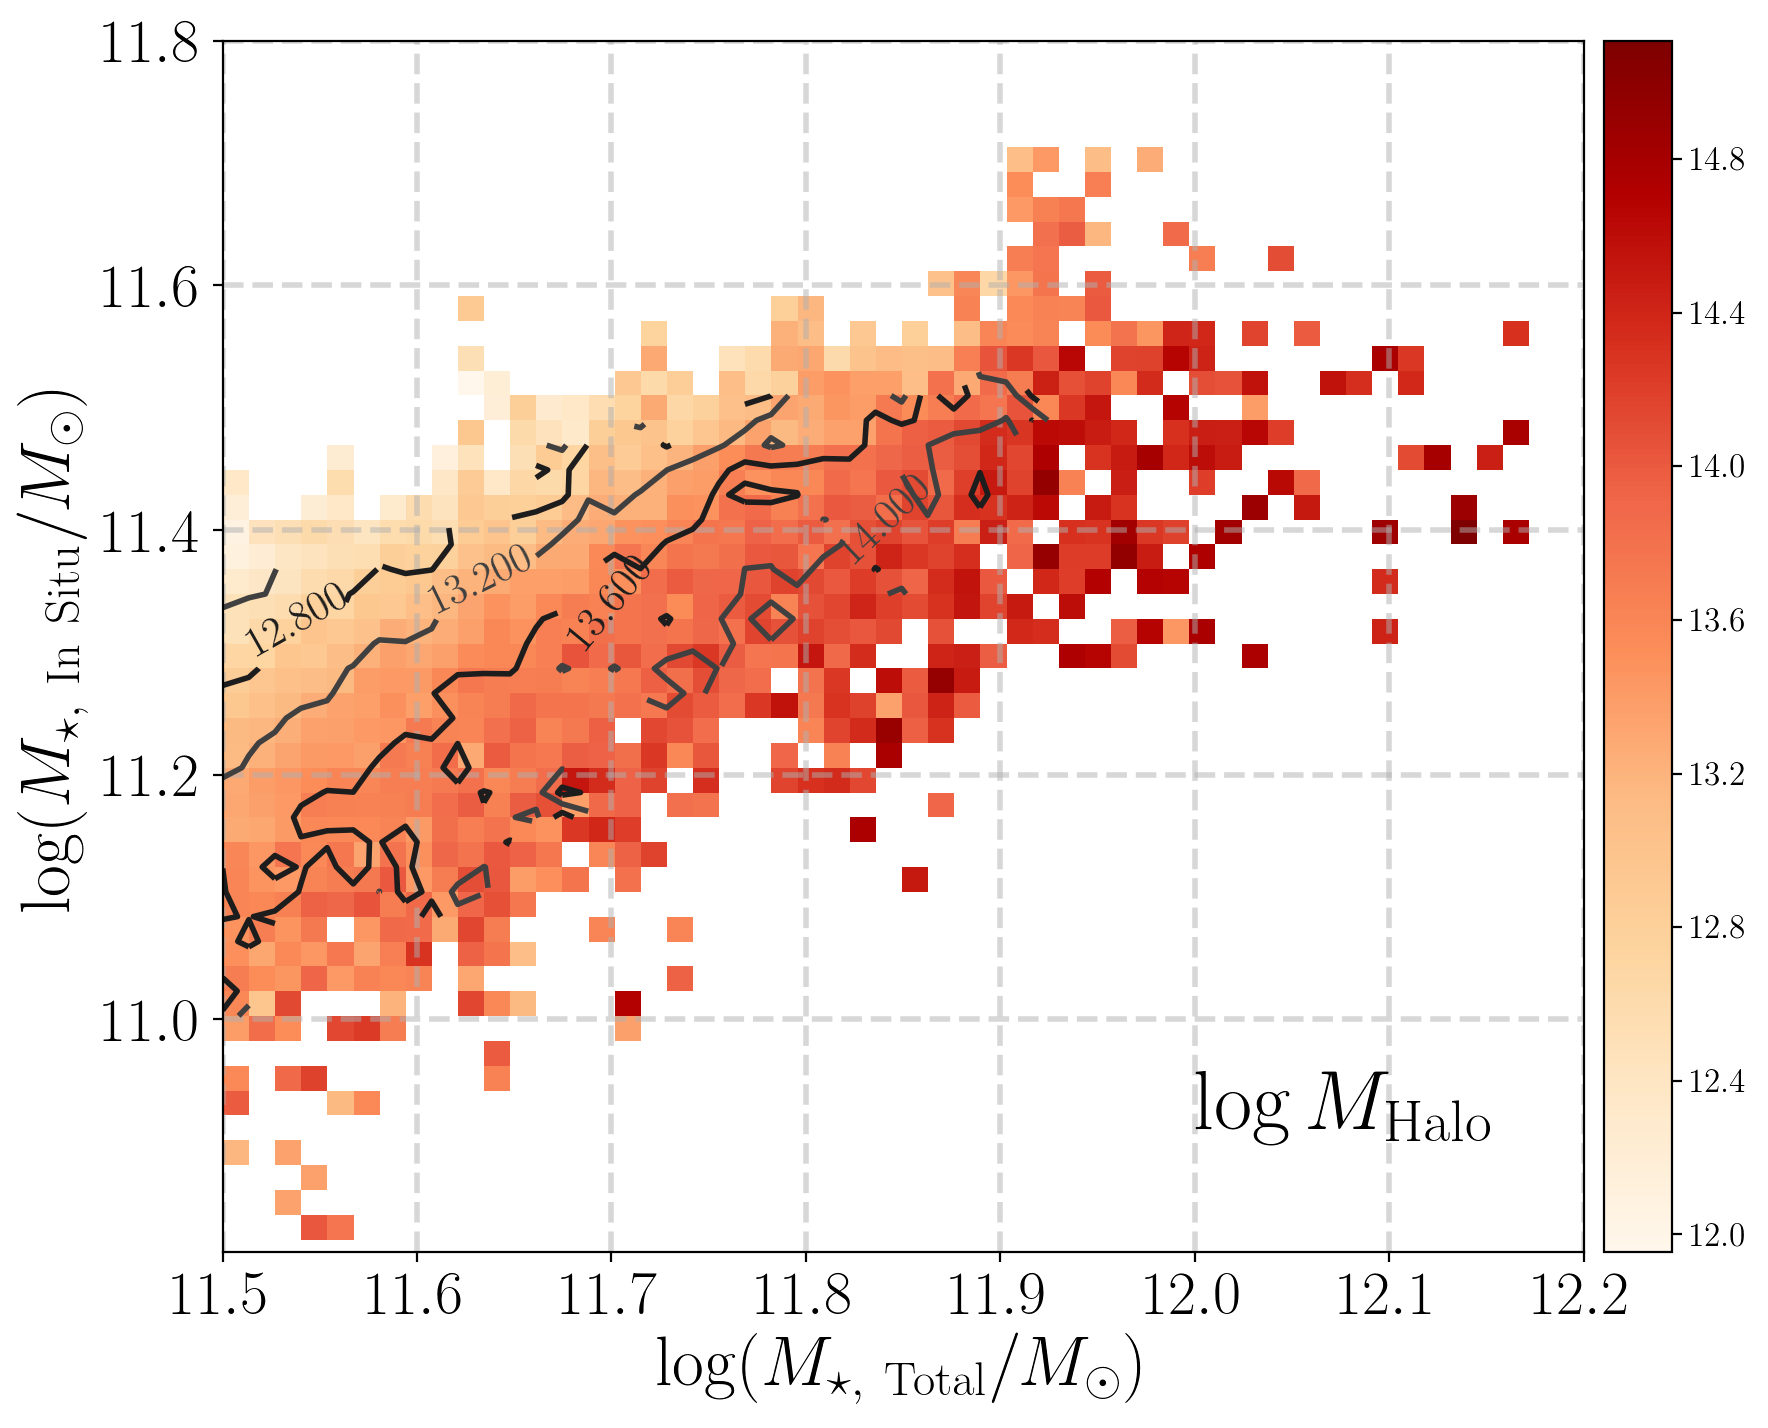

In [254]:
# --------------------------------------------------------------------------------------- #
xtickFormat='$\mathbf{%4.1f}$'
ytickFormat='$\mathbf{%4.1f}$'

ORG = plotting.ORG
BLK = plotting.BLK

nColors = 30
nTicks = 10

# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

HM = ax1.imshow(zz_median.T, origin='lower',
                extent=[xedges[0], xedges[-1], 
                        yedges[0], yedges[-1]],
                aspect='auto', interpolation='nearest', 
                cmap=ORG)

CT = ax1.contour(xedges[:-1], yedges[:-1], gaussian_filter(zz_median.T, 0.2), 
                 6, linewidths=2.0, 
                 colors=[BLK(0.8), BLK(0.9)], 
                 extend='neither')
ax1.clabel(CT, inline=1, fontsize=15)

ax1.set_xlabel('$\log (M_{\star,\ \mathrm{Total}}/M_{\odot})$', size=25)
ax1.set_ylabel('$\log (M_{\star,\ \mathrm{In\ Situ}}/M_{\odot})$', size=25)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
    
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
cTicks = MaxNLocator(nTicks).tick_values(zMin, zMax)
cbar = plt.colorbar(HM, cax=cax, ticks=cTicks)
cbar.solids.set_edgecolor("face") 

ax1.text(12.0, 10.9, r'$\log M_{\mathrm{Halo}}$', size=30)

# --------------------------------------------------------------------------------------- #
## X, Y limits
ax1.set_xlim(um_test.obs_smf_tot_min, um_test.obs_smf_tot_max)
ax1.set_ylim(10.81, um_test.obs_smf_inn_max)

#### WL only fit

In [57]:
um_test = InsituExsituModel(model_type='frac1',
                            um_mtot_nbin=100,
                            um_min_nobj_per_bin=15,
                            mcmc_wl_weight=1.0,
                            mcmc_nsamples=300, 
                            mcmc_nburnin=200, 
                            mcmc_nwalkers=128,
                            mcmc_wl_only=True)

um_test.mcmcFit()

# Input stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Input weak lensing profile sample: s16a_wide2_massive_boxbin3
# There are 15 weak lensing profiles in this sample
# Pre-computed SMF for inner logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_11.5.fits
# Pre-computed SMF for total logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m100_11.5.fits
# Pre-computed full SMF: s82_total_smf_z0.15_0.43.fits
# The volume of the HSC data is    102060083.62 Mpc^3
# Using logm_10 as inner stellar mass.
# Using logm_100 as total stellar mass.
# For inner stellar mass: 
    10 bins at 10.80 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.50 < logMtot < 12.20
# The volume of the UniverseMachine mock is    205348196.23 Mpc^3
# Setup the sampler ...
# Setup the initial guesses ...
# Phase: Burn-in ...
# Phase: MCMC run ...
# Get MCMC samples and best-fit parameters ...
#------------------------------------------------------
#  Mean acc

-869.422678323


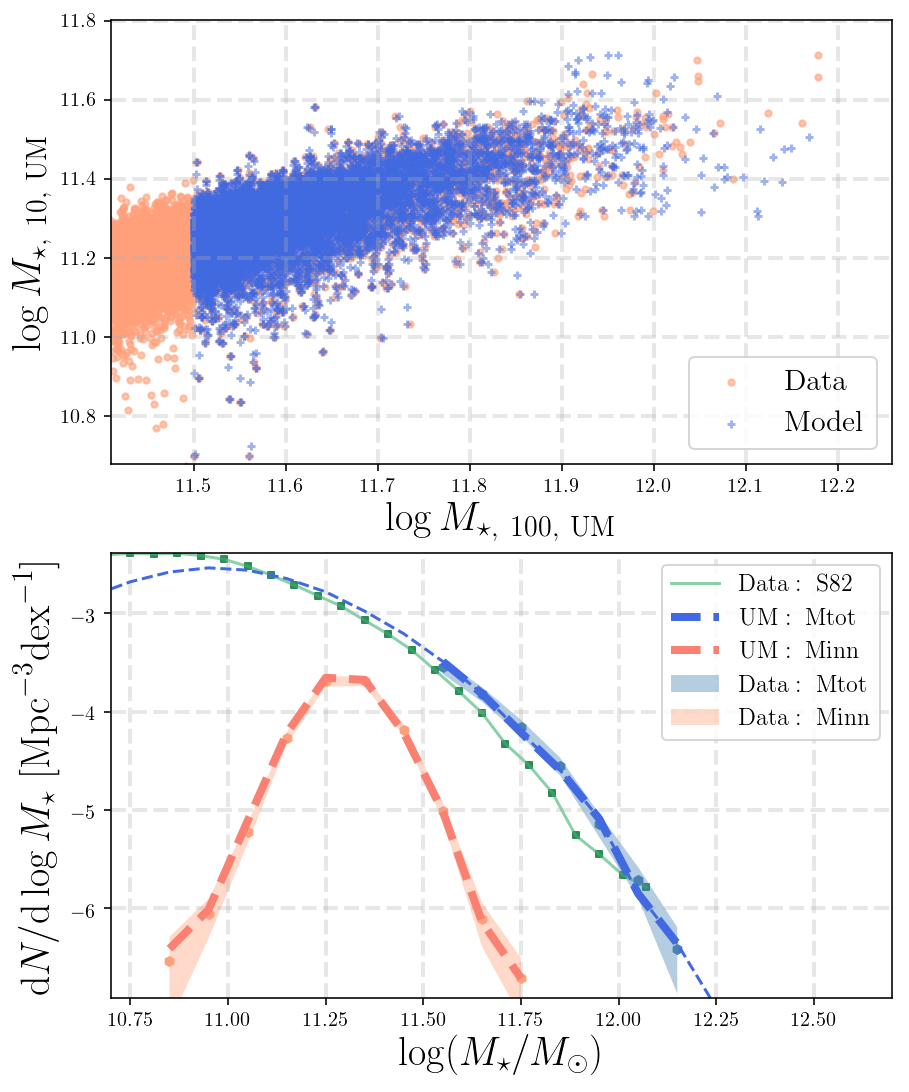

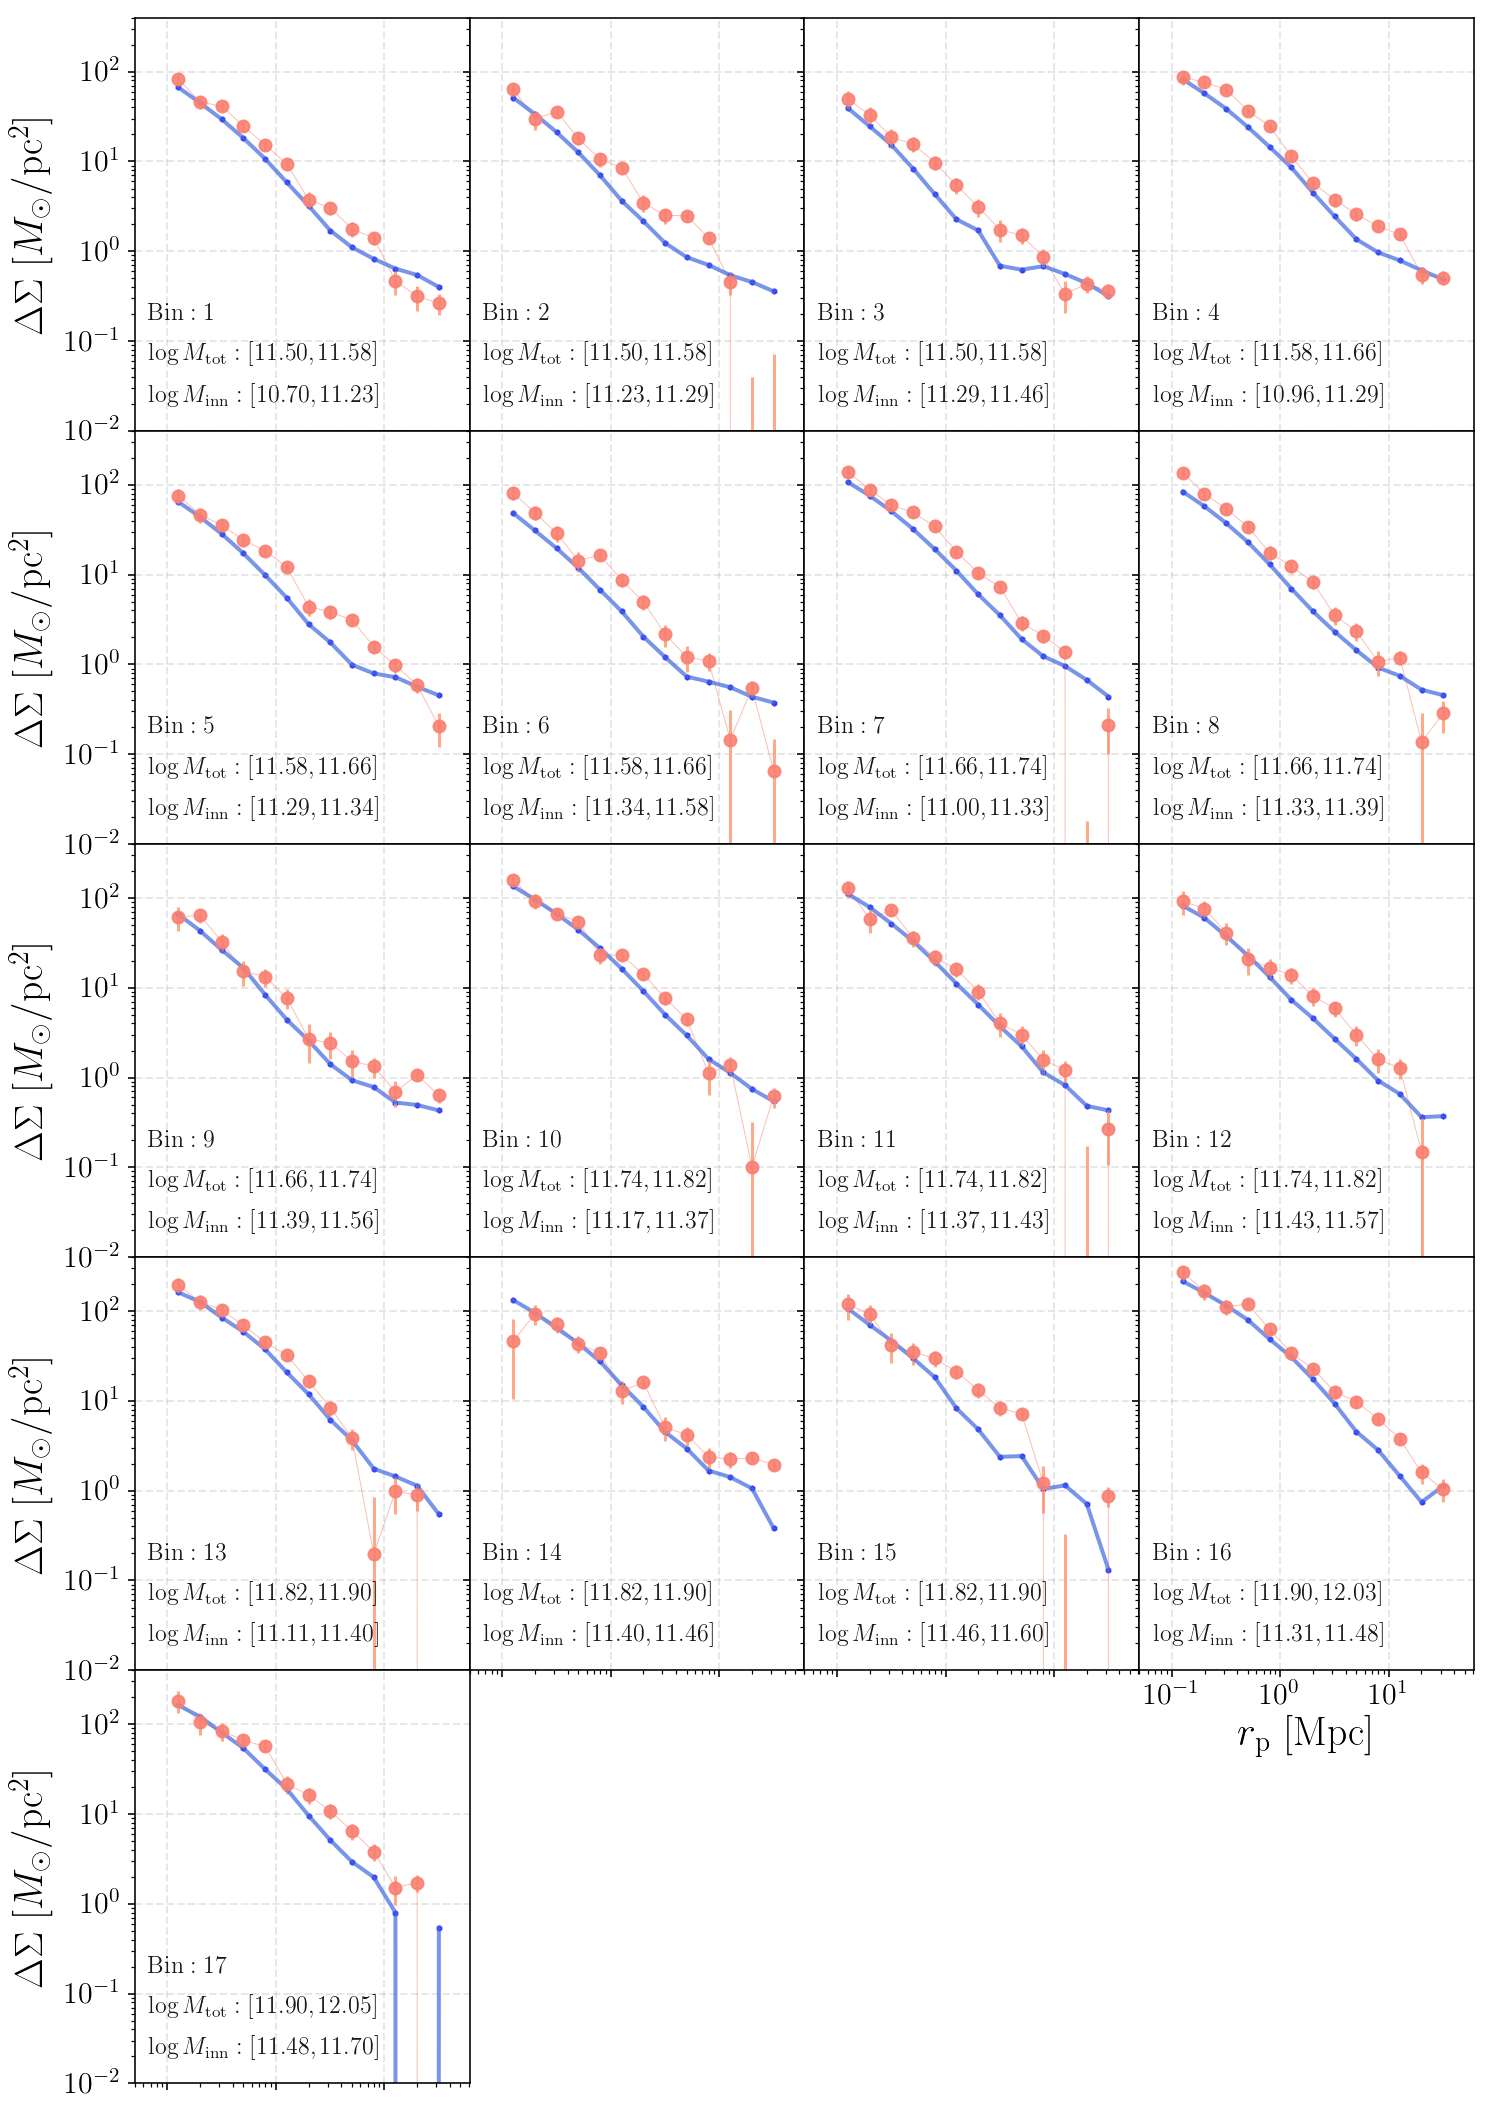

In [31]:
#param_frac1 = [0.59118957, 3.65228594,
#               -0.04815255, 0.79038771,
#               0.43632102, 0.07830234]
param_frac1 = [0.5807367054440092, 3.891653460634822,
               -0.0484849047834879, 0.7904127278329333,
               0.74614319396654816, 0.1013571711214482]

print(um_test.lnLike(param_frac1))

um_mod_predicted = um_test.umPredictModel(param_frac1, 
                                          plotSMF=True, 
                                          plotWL=True,
                                          constant_bin=False)

(um_smf_tot, um_smf_inn, um_wl_profs, 
 logms_inn_mod, logms_tot_mod, logms_halo_mod, 
 mask_tot, um_mock_use) = um_mod_predicted

In [263]:
xx = logms_tot_mod
yy = logms_inn_mod
zz = um_mock_use['logmh_vir']

xMin, xMax = np.nanmin(xx), np.nanmax(xx)
yMin, yMax = np.nanmin(yy), np.nanmax(yy)
zMin, zMax = np.nanmin(zz), np.nanmax(zz)

zz_count, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                               'count', 
                                               bins=50)

zz_median, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                                np.nanmedian, 
                                                bins=50)

zz_sigma, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                               np.nanstd, 
                                               bins=50)
xcen = (xedges[0:-2] + xedges[1:-1]) / 2
ycen = (yedges[0:-2] + yedges[1:-1]) / 2

(10.81, 11.800000000000001)

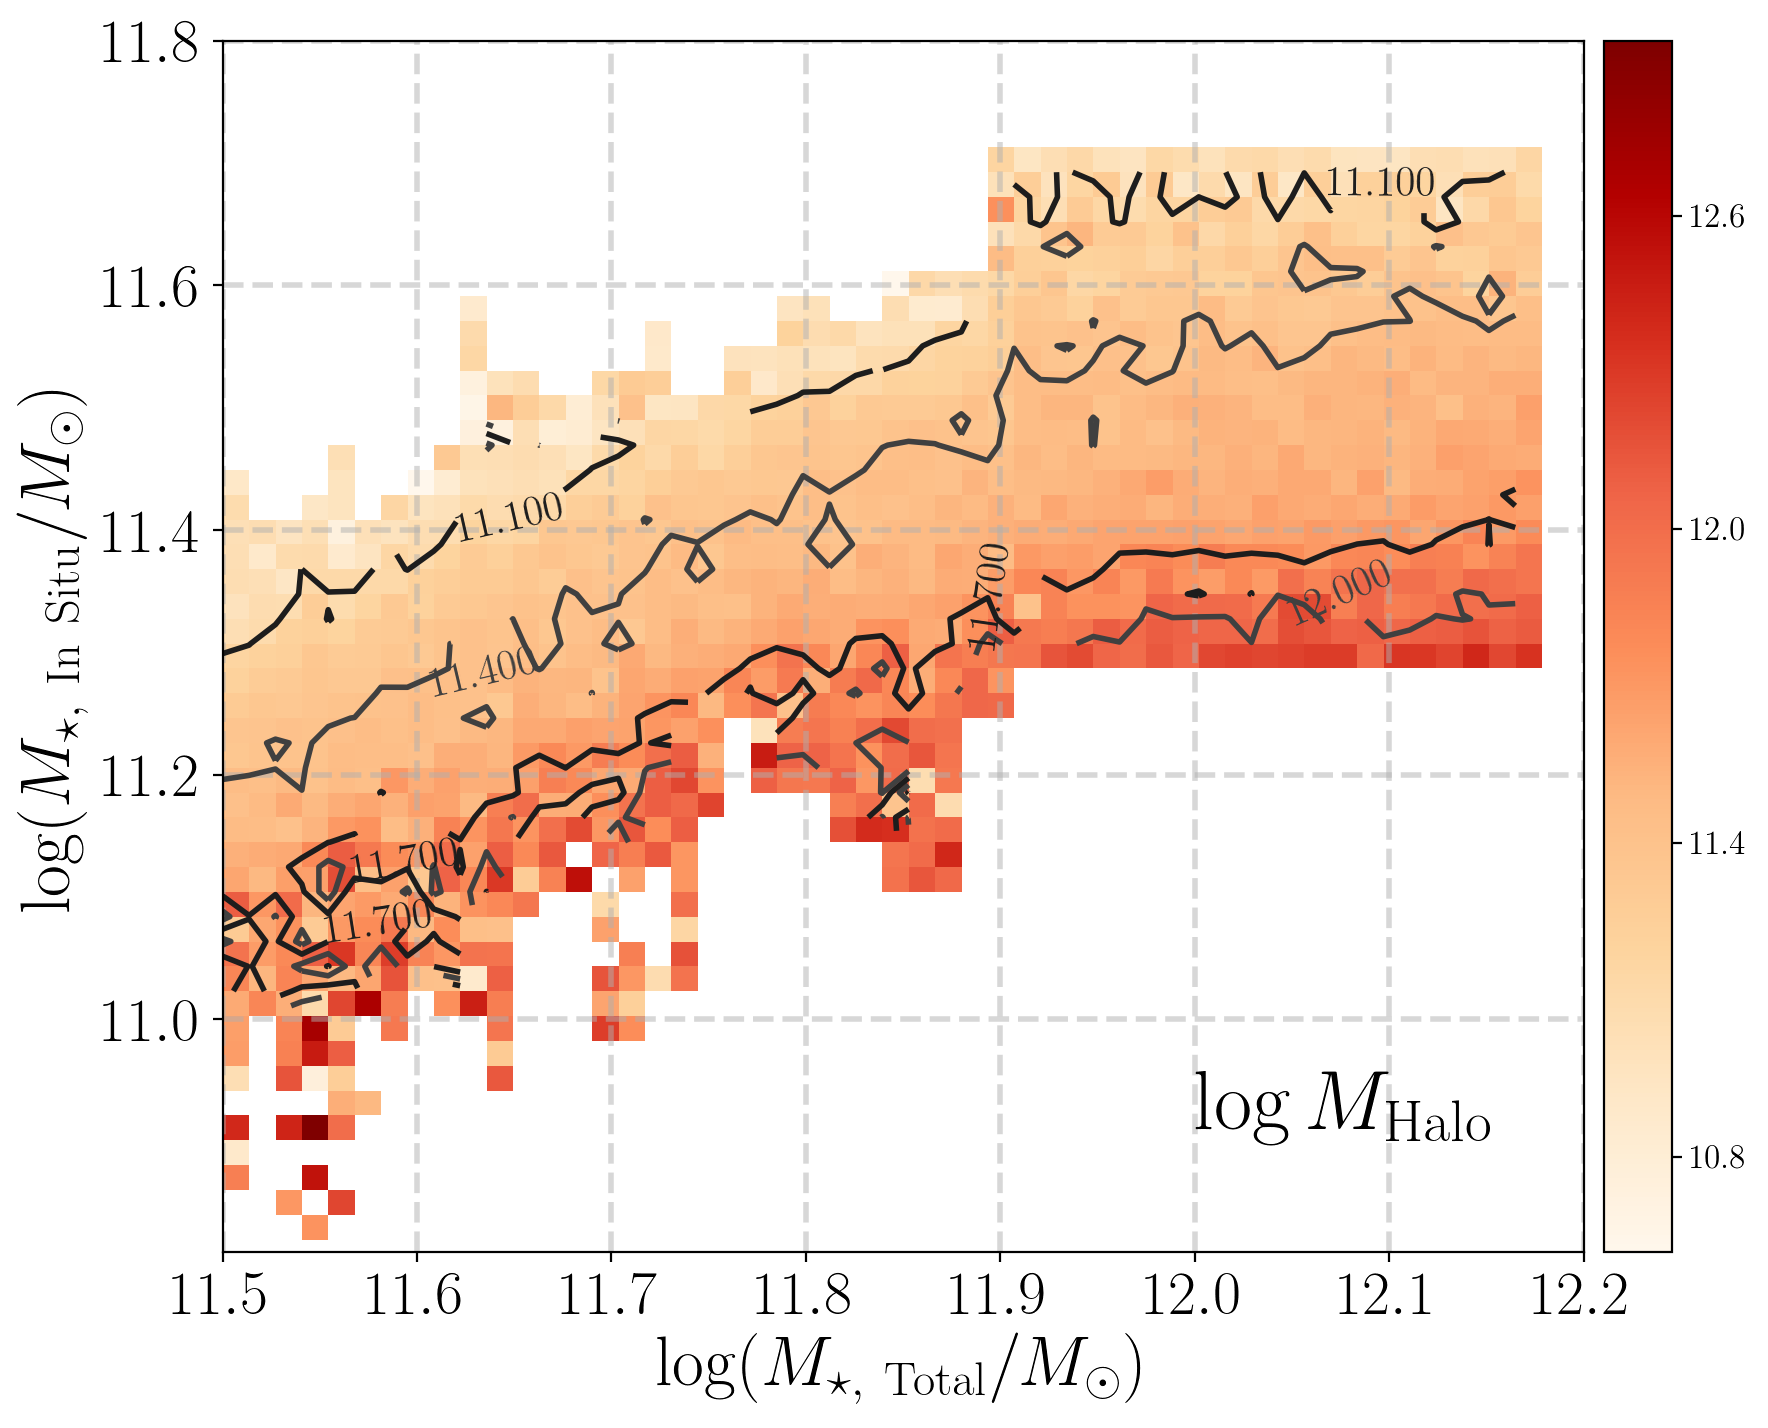

In [264]:
# --------------------------------------------------------------------------------------- #
xtickFormat='$\mathbf{%4.1f}$'
ytickFormat='$\mathbf{%4.1f}$'

ORG = plotting.ORG
BLK = plotting.BLK

nColors = 30
nTicks = 10

# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

HM = ax1.imshow(zz_median.T, origin='lower',
                extent=[xedges[0], xedges[-1], 
                        yedges[0], yedges[-1]],
                aspect='auto', interpolation='nearest', 
                cmap=ORG)

CT = ax1.contour(xedges[:-1], yedges[:-1], gaussian_filter(zz_median.T, 0.2), 
                 6, linewidths=2.0, 
                 colors=[BLK(0.8), BLK(0.9)], 
                 extend='neither')
ax1.clabel(CT, inline=1, fontsize=15)

ax1.set_xlabel('$\log (M_{\star,\ \mathrm{Total}}/M_{\odot})$', size=25)
ax1.set_ylabel('$\log (M_{\star,\ \mathrm{In\ Situ}}/M_{\odot})$', size=25)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
    
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
cTicks = MaxNLocator(nTicks).tick_values(zMin, zMax)
cbar = plt.colorbar(HM, cax=cax, ticks=cTicks)
cbar.solids.set_edgecolor("face") 

ax1.text(12.0, 10.9, r'$\log M_{\mathrm{Halo}}$', size=30)

# --------------------------------------------------------------------------------------- #
## X, Y limits
ax1.set_xlim(um_test.obs_smf_tot_min, um_test.obs_smf_tot_max)
ax1.set_ylim(10.81, um_test.obs_smf_inn_max)

#### SMF + WL fits

In [58]:
um_test = InsituExsituModel(model_type='frac1',
                            um_mtot_nbin=100,
                            um_min_nobj_per_bin=15,
                            mcmc_wl_weight=1.0,
                            mcmc_nsamples=300, 
                            mcmc_nburnin=200, 
                            mcmc_nwalkers=256,
                            mcmc_smf_only=True)

um_test.mcmcFit()

# Input stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Input weak lensing profile sample: s16a_wide2_massive_boxbin3
# There are 15 weak lensing profiles in this sample
# Pre-computed SMF for inner logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_11.5.fits
# Pre-computed SMF for total logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m100_11.5.fits
# Pre-computed full SMF: s82_total_smf_z0.15_0.43.fits
# The volume of the HSC data is    102060083.62 Mpc^3
# Using logm_10 as inner stellar mass.
# Using logm_100 as total stellar mass.
# For inner stellar mass: 
    10 bins at 10.80 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.50 < logMtot < 12.20
# The volume of the UniverseMachine mock is    205348196.23 Mpc^3
# Setup the sampler ...
# Setup the initial guesses ...
# Phase: Burn-in ...
# Phase: MCMC run ...
# Get MCMC samples and best-fit parameters ...
#------------------------------------------------------
#  Mean acc

In [4]:
um_test = InsituExsituModel(model_type='frac1', 
                            um_mtot_nbin=100,
                            obs_wl_sample='s16a_wide2_massive_boxbin1',
                            mcmc_wl_weight=1.0)

# Input stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Input weak lensing profile sample: s16a_wide2_massive_boxbin1
# There are 17 weak lensing profiles in this sample
# Pre-computed SMF for inner logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_11.5.fits
# Pre-computed SMF for total logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m100_11.5.fits
# Pre-computed full SMF: s82_total_smf_z0.15_0.43.fits
# The volume of the HSC data is    102060083.62 Mpc^3
# Using logm_10 as inner stellar mass.
# Using logm_100 as total stellar mass.
# For inner stellar mass: 
    10 bins at 10.80 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.50 < logMtot < 12.20
# The volume of the UniverseMachine mock is    205348196.23 Mpc^3


-954.726636349


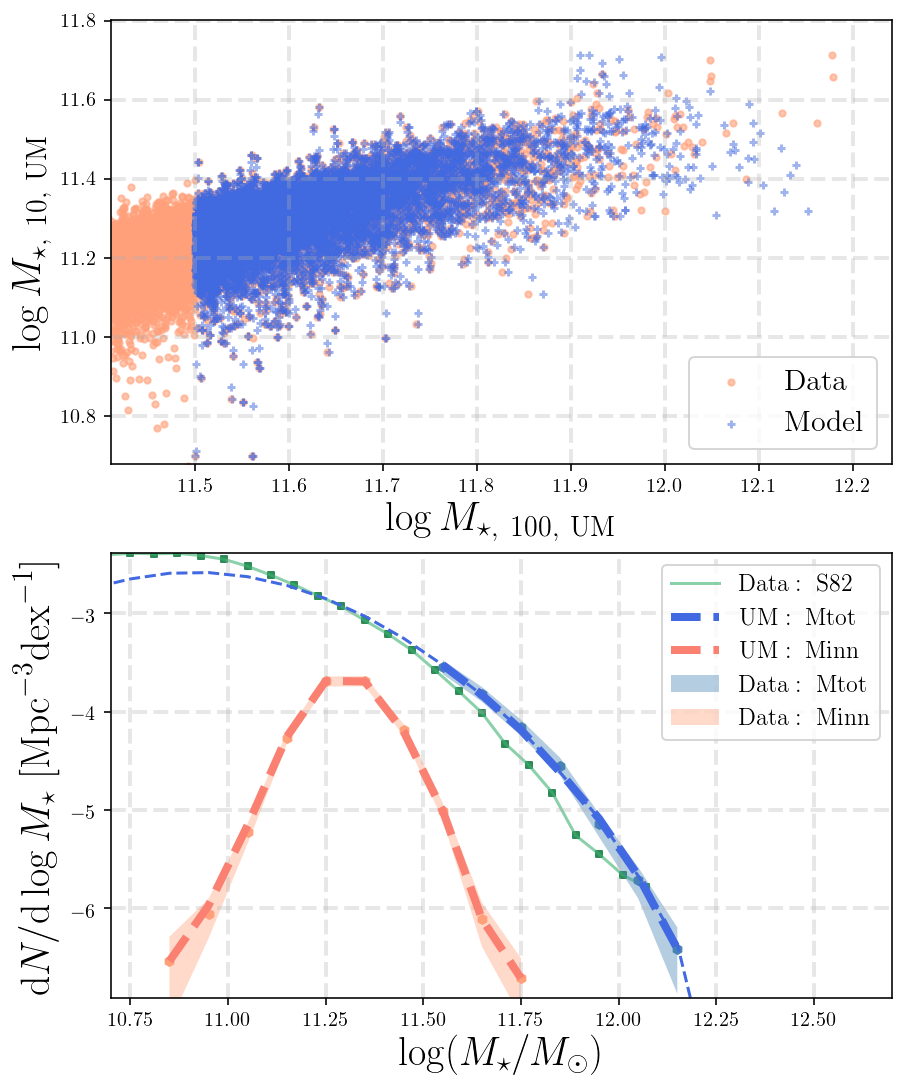

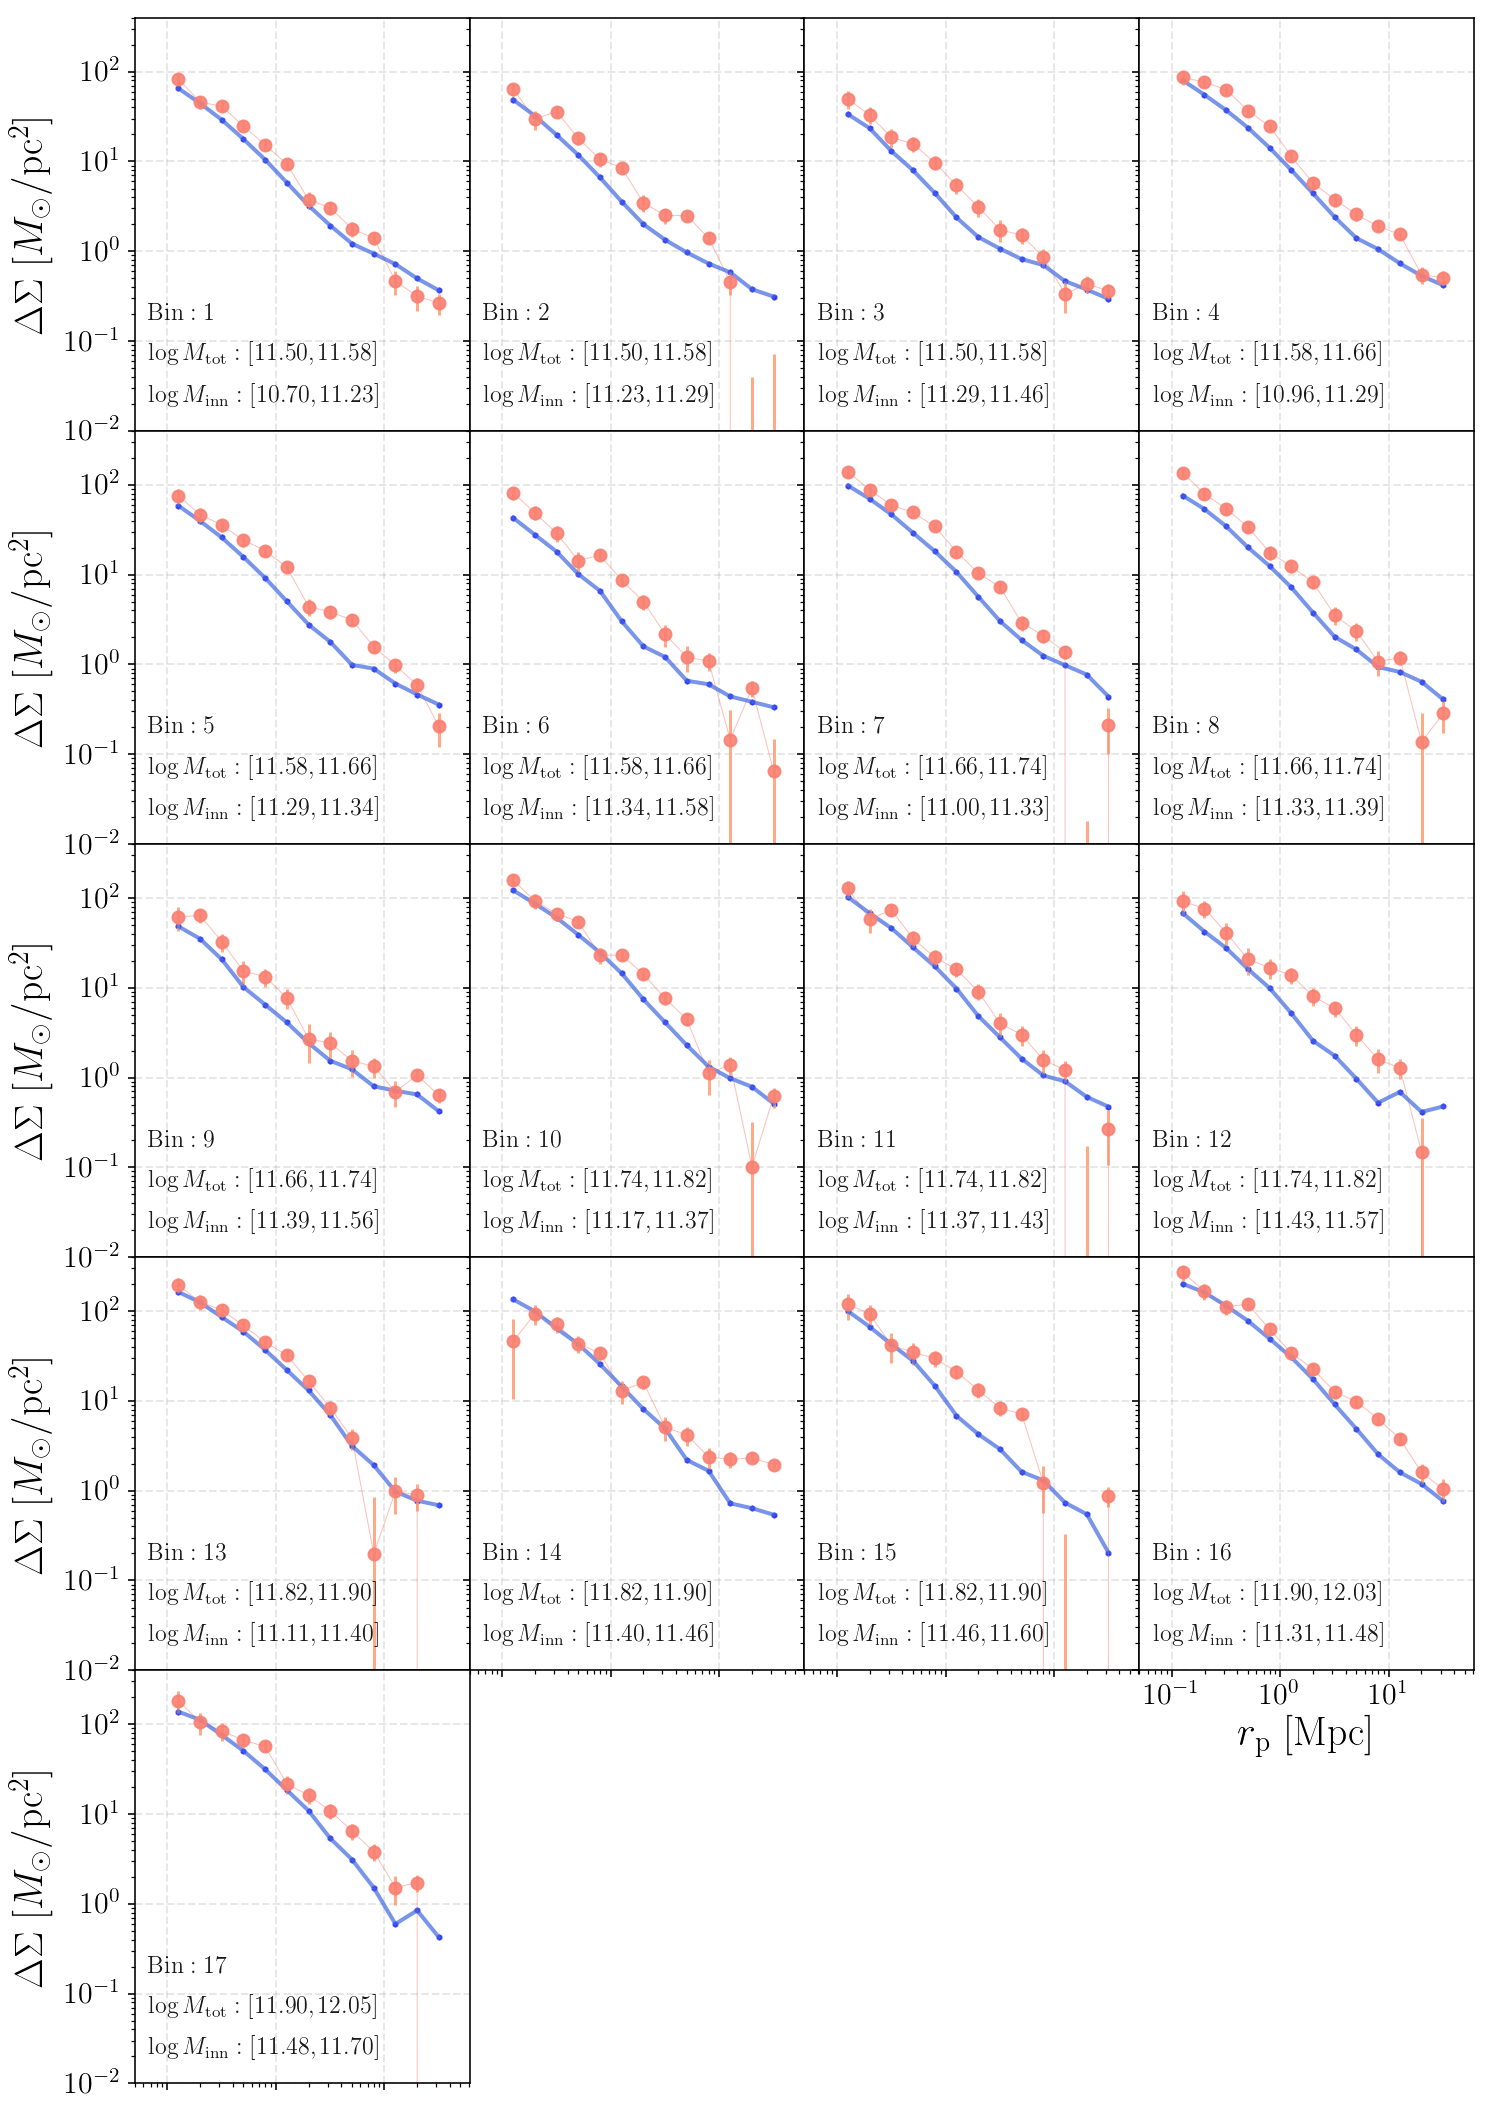

In [32]:
param_frac1 = (0.59720207, 3.63718396, -0.06260955, 0.99768758, 0.80876638, 0.16496104)
#param_frac1 = (0.5741614, 4.04289, -0.1030, 1.3649, 0.7498, 0.1517)

print(um_test.lnLike(param_frac1))

um_mod_predicted = um_test.umPredictModel(param_frac1, 
                                          plotSMF=True, 
                                          plotWL=True,
                                          constant_bin=False)

(um_smf_tot, um_smf_inn, um_wl_profs, 
 logms_inn_mod, logms_tot_mod, logms_halo_mod, 
 mask_tot, um_mock_use) = um_mod_predicted

Text(0,0.5,u'$\\sigma_{\\log M_{\\star, \\rm Total}}$')

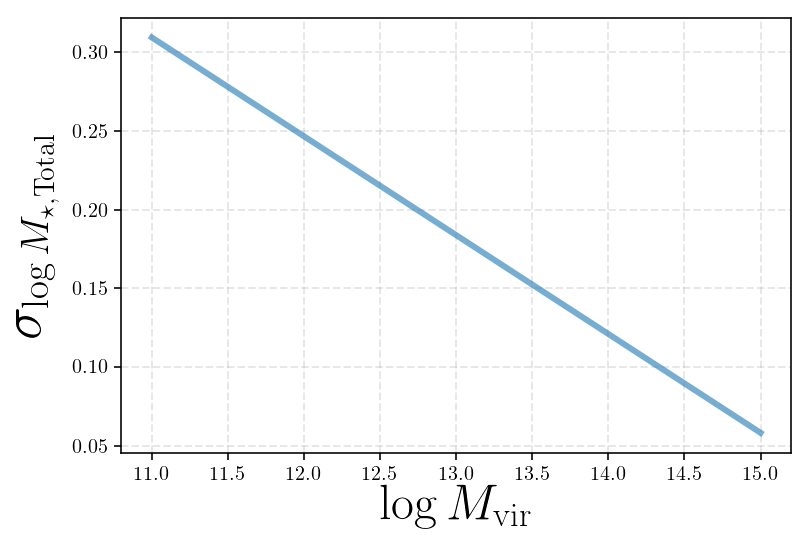

In [6]:
logmh_bin = np.linspace(11.0, 15.0, 20)
plt.grid(linewidth=1, alpha=0.3, linestyle='--')
plt.plot(logmh_bin, -0.06260955 * logmh_bin + 0.99768758, 
         alpha=0.6, linewidth=3)
plt.xlabel(r'$\log M_{\mathrm{vir}}$', fontsize=25)
plt.ylabel(r'$\sigma_{\log M_{\star, \rm Total}}$',               
           fontsize=28)

In [7]:
xx = logms_tot_mod
yy = logms_inn_mod
zz = um_mock_use['logmh_vir']

xMin, xMax = np.nanmin(xx), np.nanmax(xx)
yMin, yMax = np.nanmin(yy), np.nanmax(yy)
zMin, zMax = np.nanmin(zz), np.nanmax(zz)

zz_count, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                               'count', 
                                               bins=50)

zz_median, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                                np.nanmedian, 
                                                bins=50)

zz_sigma, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                               np.nanstd, 
                                               bins=50)
xcen = (xedges[0:-2] + xedges[1:-1]) / 2
ycen = (yedges[0:-2] + yedges[1:-1]) / 2

/usr/local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:990: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


(10.81, 11.800000000000001)

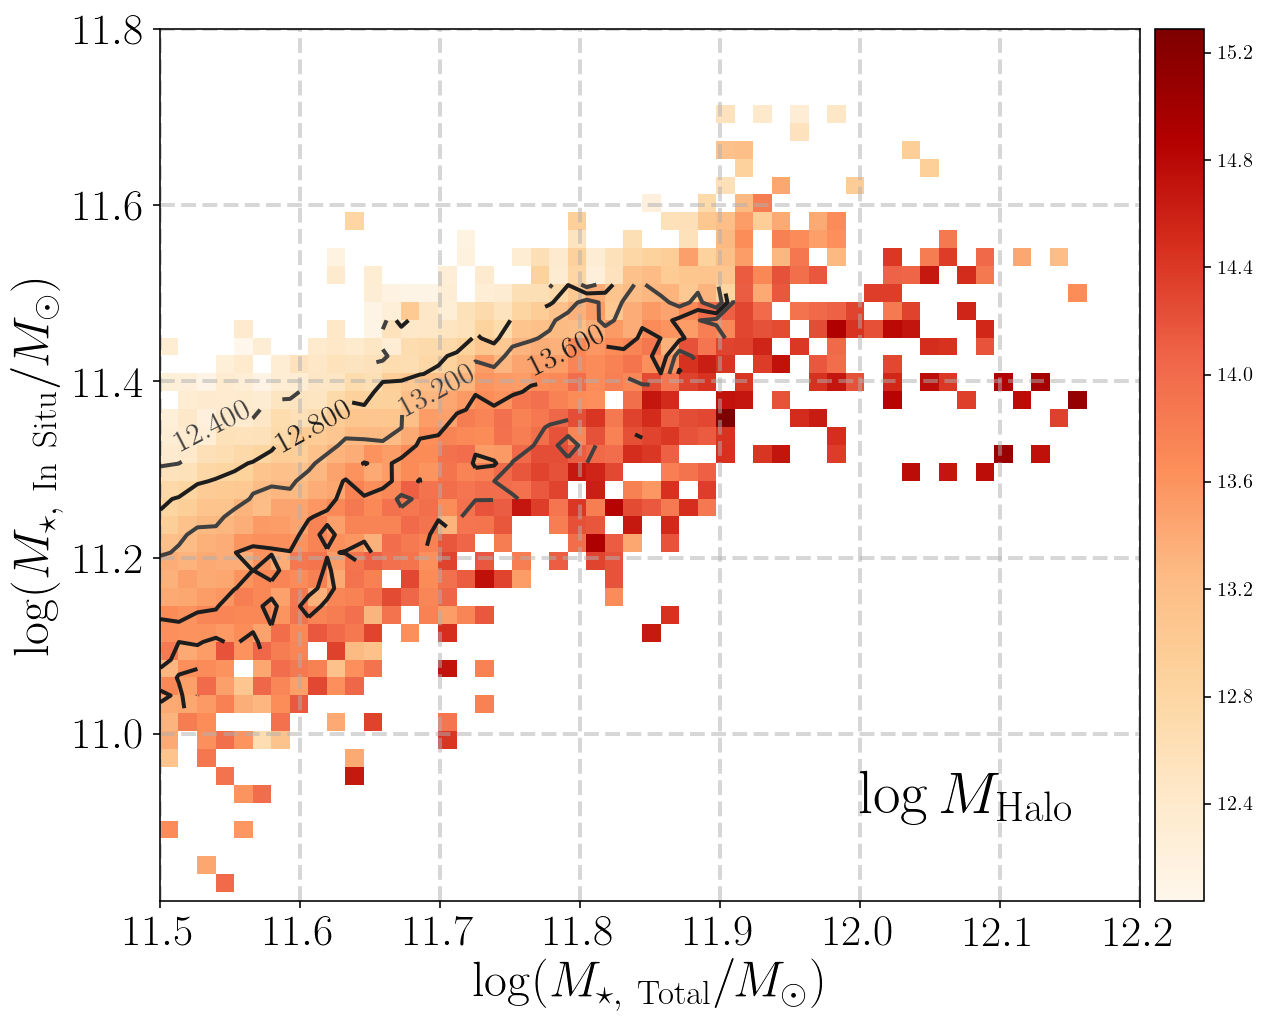

In [8]:
# --------------------------------------------------------------------------------------- #
xtickFormat='$\mathbf{%4.1f}$'
ytickFormat='$\mathbf{%4.1f}$'

ORG = plotting.ORG
BLK = plotting.BLK

nColors = 30
nTicks = 10

# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

HM = ax1.imshow(zz_median.T, origin='lower',
                extent=[xedges[0], xedges[-1], 
                        yedges[0], yedges[-1]],
                aspect='auto', interpolation='nearest', 
                cmap=ORG)

CT = ax1.contour(xedges[:-1], yedges[:-1], gaussian_filter(zz_median.T, 0.2), 
                 6, linewidths=2.0, 
                 colors=[BLK(0.8), BLK(0.9)], 
                 extend='neither')
ax1.clabel(CT, inline=1, fontsize=15)

ax1.set_xlabel('$\log (M_{\star,\ \mathrm{Total}}/M_{\odot})$', size=25)
ax1.set_ylabel('$\log (M_{\star,\ \mathrm{In\ Situ}}/M_{\odot})$', size=25)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
    
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
cTicks = MaxNLocator(nTicks).tick_values(zMin, zMax)
cbar = plt.colorbar(HM, cax=cax, ticks=cTicks)
cbar.solids.set_edgecolor("face") 

ax1.text(12.0, 10.9, r'$\log M_{\mathrm{Halo}}$', size=30)

# --------------------------------------------------------------------------------------- #
## X, Y limits
ax1.set_xlim(um_test.obs_smf_tot_min, um_test.obs_smf_tot_max)
ax1.set_ylim(10.81, um_test.obs_smf_inn_max)